This file is part of BrainMolecularAtlas.

Copyright (c) 2021 Blue Brain Project/EPFL 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import altair as alt

import re

import pickle as pkl

import scipy.stats as st

from matplotlib.cbook import boxplot_stats

import timeit
from collections import Counter

from numpy.random import seed
from numpy.random import randint
from scipy.stats import ks_2samp
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
from helper_functions import (
    variability_score,
    split_df_column_list_to_multiple_rows
)

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid',{'axes.grid':False})

In [4]:
with open('../data/6_df_processed.pkl','rb') as f:
    df = pkl.load(f)

In [5]:
print(len(df['gene_id_final'].unique()))

print(len(df['Study'].unique()))

print(len(df.loc[df['log_conc_uM'].isna()]))

print(len(df))

14700
25
0
2131244


### Plots

In [7]:
#find genes with the highest number of datasets reporting them

genesInStudiesNum = df[['gene_id_final','Study']].groupby('gene_id_final').nunique()

print(len(genesInStudiesNum[genesInStudiesNum['Study']==np.max(genesInStudiesNum['Study'])]))

genesInStudiesNumMax = genesInStudiesNum[genesInStudiesNum['Study']==np.max(genesInStudiesNum['Study'])]
genesInStudiesNumMax = genesInStudiesNumMax.drop(columns='gene_id_final')
genesInStudiesNumMax = genesInStudiesNumMax.reset_index()
#genesInStudiesNumMax

def get_entry_counts(gene_id):
    return(len(df[df['gene_id_final']==gene_id]))

74


In [8]:
genesInStudiesNumMax['entry_counts'] = genesInStudiesNumMax['gene_id_final'].map(get_entry_counts)
len(genesInStudiesNumMax)

74

In [ ]:
genesInStudiesNumMax[genesInStudiesNumMax['entry_counts']==np.max(genesInStudiesNumMax['entry_counts'])]

In [11]:
len(df['Study'].unique())

25

In [12]:
#STXBP1

set(df['Study'].unique().tolist()) - set(df.loc[df['gene_id_final']=='STXBP1','Study'].unique().tolist())


{'Duda 2018'}

In [13]:
df.loc[(df['Study']=='Duda 2018') & (df['gene_names'].str.contains('STXBP1'))]

Empty DataFrame
Columns: [gene_names, Uniprot, Study, Organism, location, Age_cat, Age_days, condition, sample_id, molecular_weight_kDa, raw_data, raw_data_units, gene_name_unified, Uniprot_unified, gene_id_final, log_raw_data, uniprot_from_gn, Uniprot_final, TheorPepNum, conc_uM, log_conc_uM, copyNum, totalProtein, totalVolume, sample_full_id, compound_gene_protein_id, row_id, row_gene_id, gene_id_dd, log_conc_uM_medNorm]
Index: []

In [14]:
df['condition'].unique()

array([nan, 'AD', 'control',
       'AD: late-stage AD with high pathology scores of plaques and tangles',
       'PSP: progressive supranuclear palsy, another neurodegenerative disorder of tauopathy',
       'MCI: mild cognitive impairment with Ab pathology and a slight but measurable defect in cognition. AD',
       'HPC: high Ab pathology but no detectable cognitive defects. AD',
       'LPC: low pathology of plaques and tangles. AD', 'EAE', 'WT',
       'Alzheimer', 'AD_severe', 'AD_intermediate', 'SORT', 'young',
       'adult'], dtype=object)

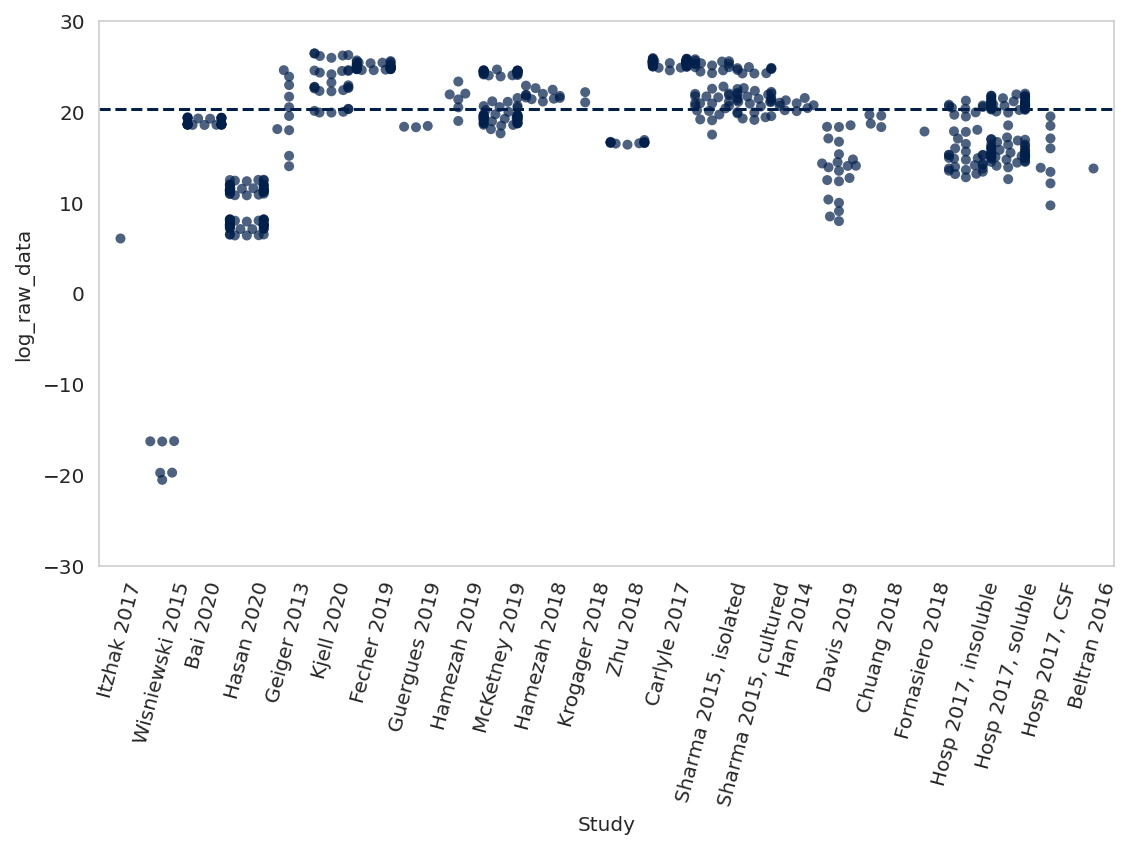

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axhline(y=np.median(df.loc[df['gene_id_final']=='STXBP1','log_raw_data']), color='#011f4b', linestyle="dashed")
ax = sns.swarmplot(x="Study", y="log_raw_data", data=df[df['gene_id_final']=='STXBP1'], alpha=0.7, size=5, color='#011f4b')

ax.grid(False)

plt.xticks(rotation=75)
ax.set_ylabel('log_raw_data')

plt.ylim([-30,30])
fig.tight_layout()

plt.show()

#fig.savefig('../plots/fig1a_STXBP1_rawUnits_28july2020.png', dpi=300,  transparent=True)
#fig.savefig('../plots/fig1a_STXBP1_rawUnits_28july2020.svg', transparent=True)


# fig 1 a

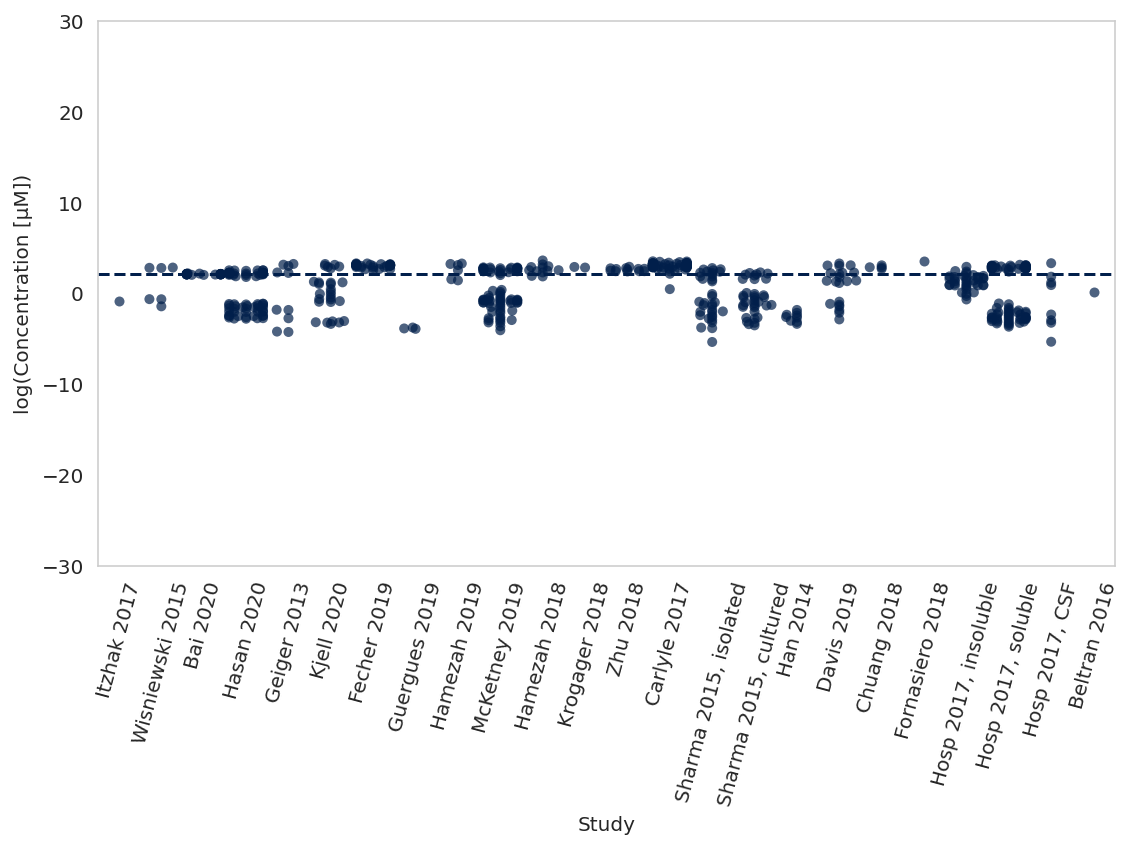

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axhline(y=np.median(df.loc[df['gene_id_final']=='STXBP1','log_conc_uM']), color='#011f4b', linestyle="dashed")  #log conc uM median norm
ax = sns.swarmplot(x="Study", y="log_conc_uM", data=df[df['gene_id_final']=='STXBP1'], alpha=0.7, size=5, color='#011f4b')  #log conc uM median norm

ax.grid(False)

plt.xticks(rotation=75)
ax.set_ylabel('log(Concentration [µM])')
plt.ylim([-30,30])

fig.tight_layout()

plt.show()

#fig.savefig('../plots/fig1abextra_STXBP1_concBeforeNorm_28july2020.png', dpi=300,  transparent=True)
#fig.savefig('../plots/fig1abextra_STXBP1_concBeforeNorm_28july2020.svg', transparent=True)


# fig 1 ab extra -> supp

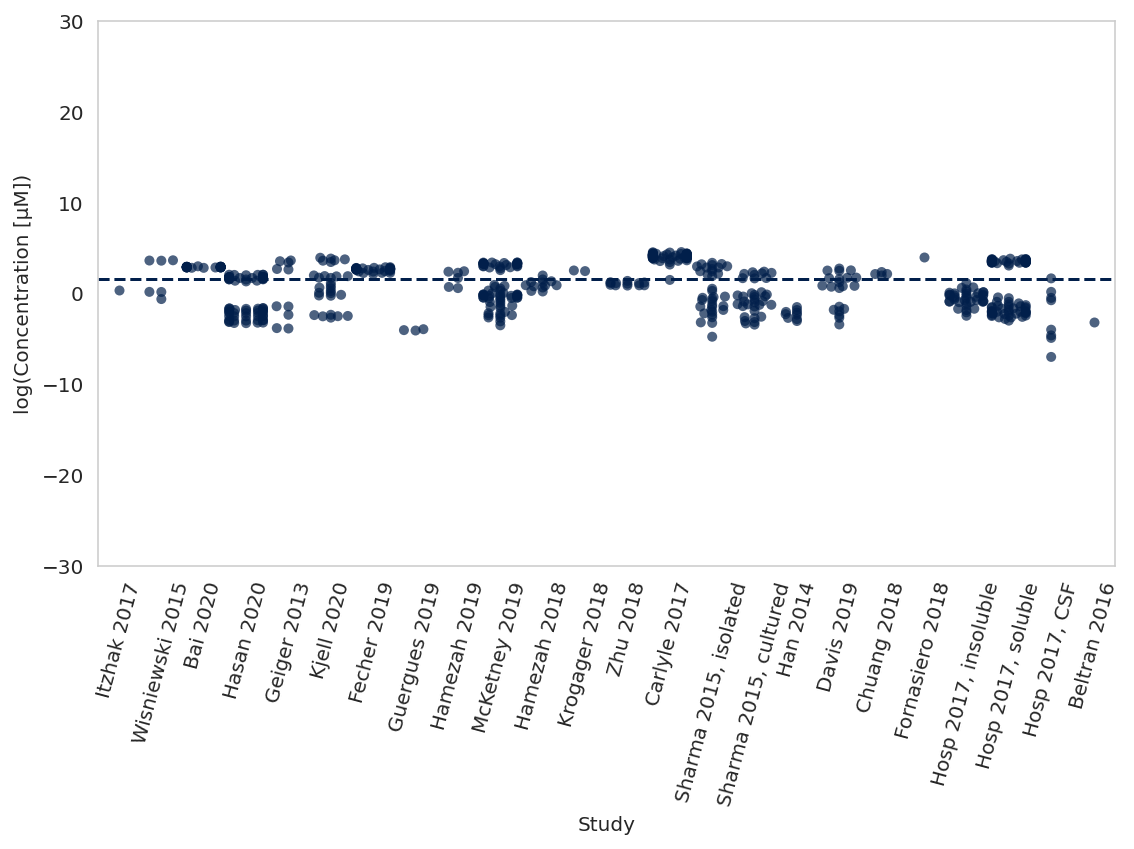

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axhline(y=np.median(df.loc[df['gene_id_final']=='STXBP1','log_conc_uM_medNorm']), color='#011f4b', linestyle="dashed")  #log conc uM median norm
ax = sns.swarmplot(x="Study", y="log_conc_uM_medNorm", data=df[df['gene_id_final']=='STXBP1'], alpha=0.7, size=5, color='#011f4b')  #log conc uM median norm

ax.grid(False)
plt.xticks(rotation=75)

ax.set_ylabel('log(Concentration [µM])')
plt.ylim([-30,30])

fig.tight_layout()

plt.show()

#fig.savefig('../plots/fig1b_STXBP1_concAfterMedNorm_28july2020.png', dpi=300,  transparent=True)
#fig.savefig('../plots/fig1b_STXBP1_concAfterMedNorm_28july2020.svg', transparent=True)


# fig 1 b

In [24]:
boxdata = df.loc[df['Study']=='Hasan 2020','log_conc_uM']

boxres = boxplot_stats(boxdata)[0] # 0 just because of data structure 

print("sample size: ", len(boxdata))
print("center line (median): ", "%.2f" % boxres['med'], "; ", \
      "upper and lower quartiles: Q1:", "%.2f" % boxres['q1'],", Q3: ", "%.2f" % boxres['q3'], "; ",  \
      "whiskers, 1.5x interquartile range: ", "%.2f" % boxres['whislo'], ", ","%.2f" % boxres['whishi'],"; ",  \
      "outliers: ", boxres['fliers'] )

sample size:  260202
center line (median):  -1.82 ;  upper and lower quartiles: Q1: -3.06 , Q3:  -0.67 ;  whiskers, 1.5x interquartile range:  -6.65 ,  2.93 ;  outliers:  [-7.35945994 -7.87420359 -6.79624637 ...  3.33149152  3.33506475
  3.06373506]


In [25]:
df['raw_data_units'].unique()

array(['Median cellular concentration [nM]',
       'Protein concentration (mol/g protein)', 'tmt abundance',
       'IntensityL', 'LFQintensity', 'iBAQ',
       'Mean concentration [mol/(g total protein)]'], dtype=object)

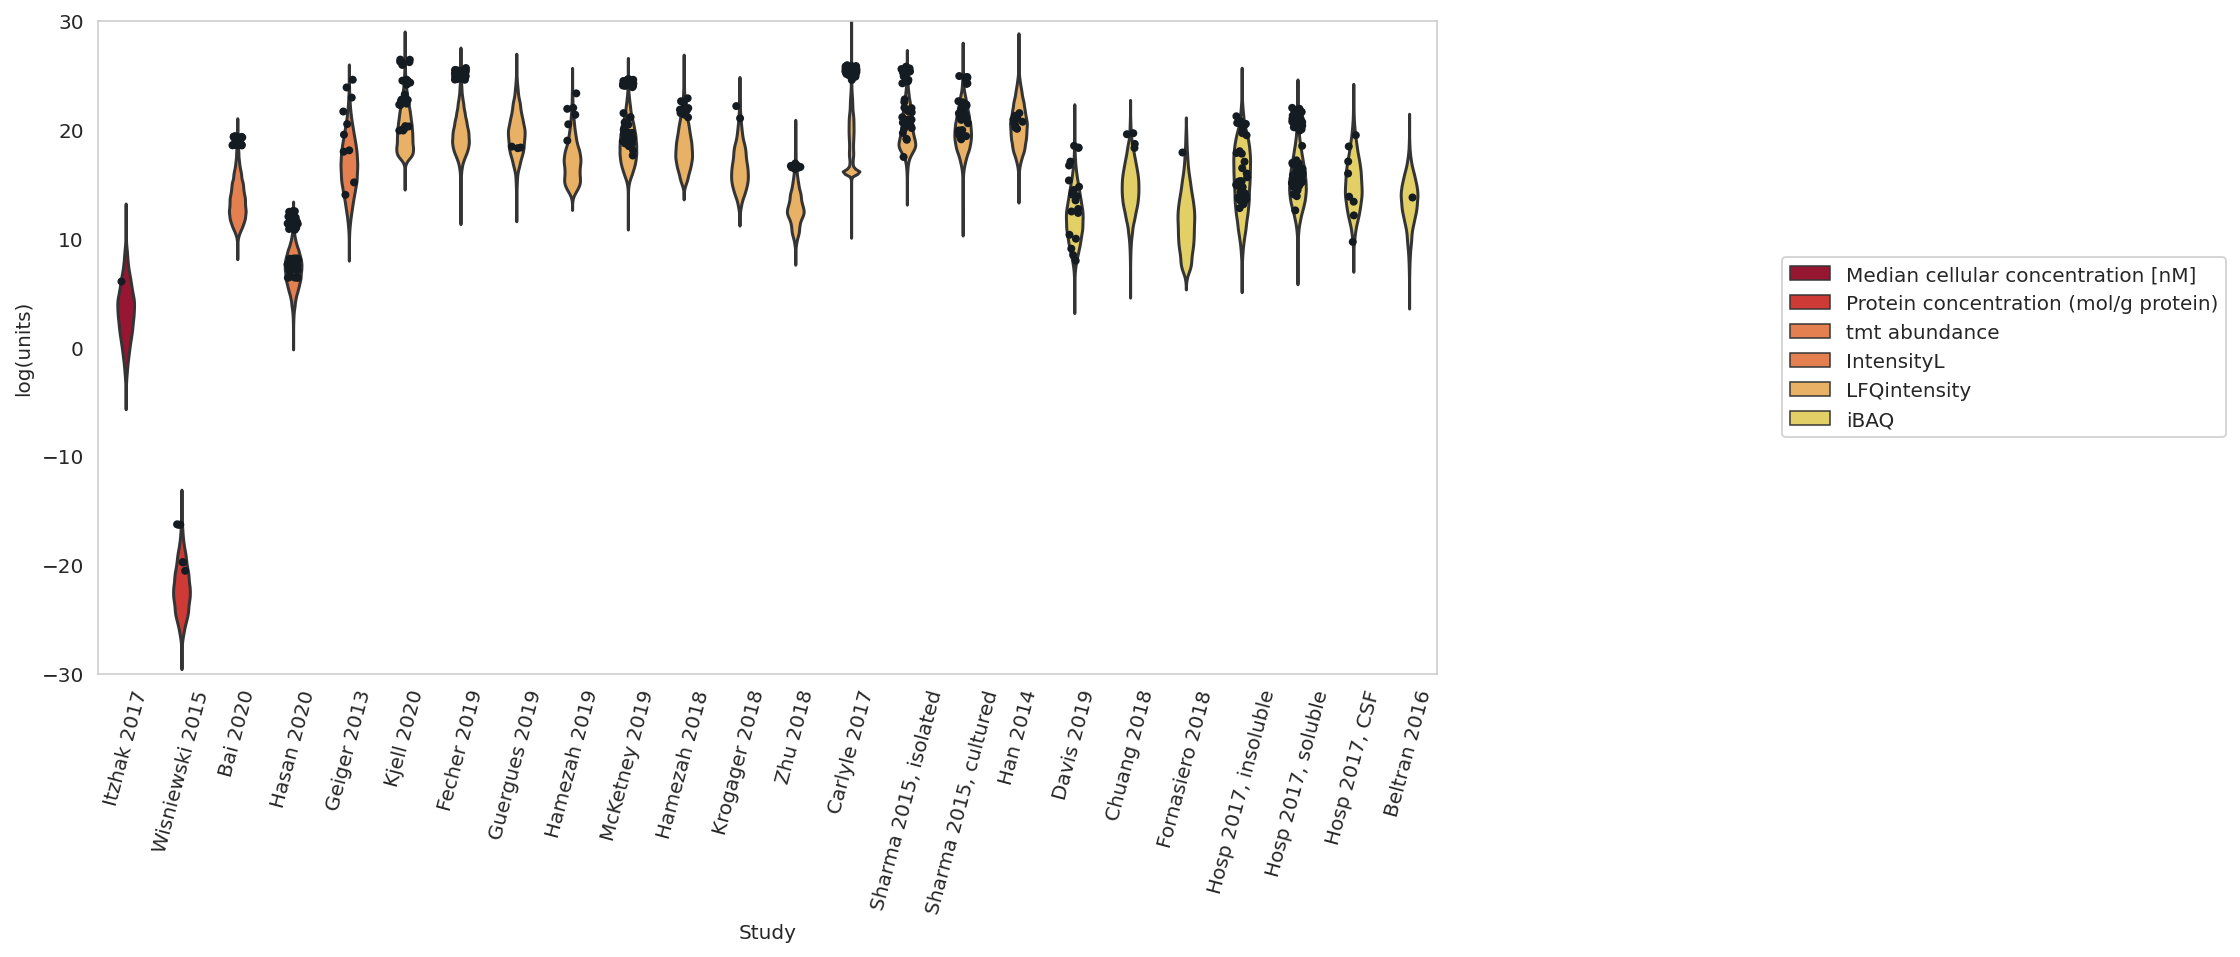

In [26]:
fig = plt.figure(figsize=(12, 6))

my_pal = {'LFQintensity':'#feb54f','IntensityL':'#fd7636', 'Median cellular concentration [nM]':'#ac0026', 'iBAQ':'#f7de52', 
          'Protein concentration (mol/g protein)':'#e7231e','Mean concentration [mol/(g total protein)]':'#e7231e','tmt abundance':'#fd7636'}

#before norm and conc calc
ax = sns.violinplot(x="Study", y="log_raw_data", data=df.loc[df['Study'].isin(df.loc[df['gene_id_final']=='STXBP1','Study'].unique())],dodge=False,inner=None,width=0.3,
                    hue='raw_data_units', palette=my_pal,zorder=1 ) #,fliersize=2)


ax = sns.stripplot(x="Study", y="log_raw_data", data=df.loc[df['Study'].isin((df.loc[df['gene_id_final']=='STXBP1','Study'].unique())) & (df['gene_id_final']=='STXBP1')],
                   alpha=1.0, size=4, color='#141c22', zorder=2)

ax.grid(False)
plt.xticks(rotation=75)
ax.set_ylabel('log(units)')

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.ylim([-30,30])

plt.show()

#fig.savefig('../plots/fig1d_violinsWithSTXBP1_rawUnitsBeforeNormaliz_28july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1d_violinsWithSTXBP1_rawUnitsBeforeNormaliz_28july2020.svg', bbox_inches='tight', transparent=True)

# fig 1 d

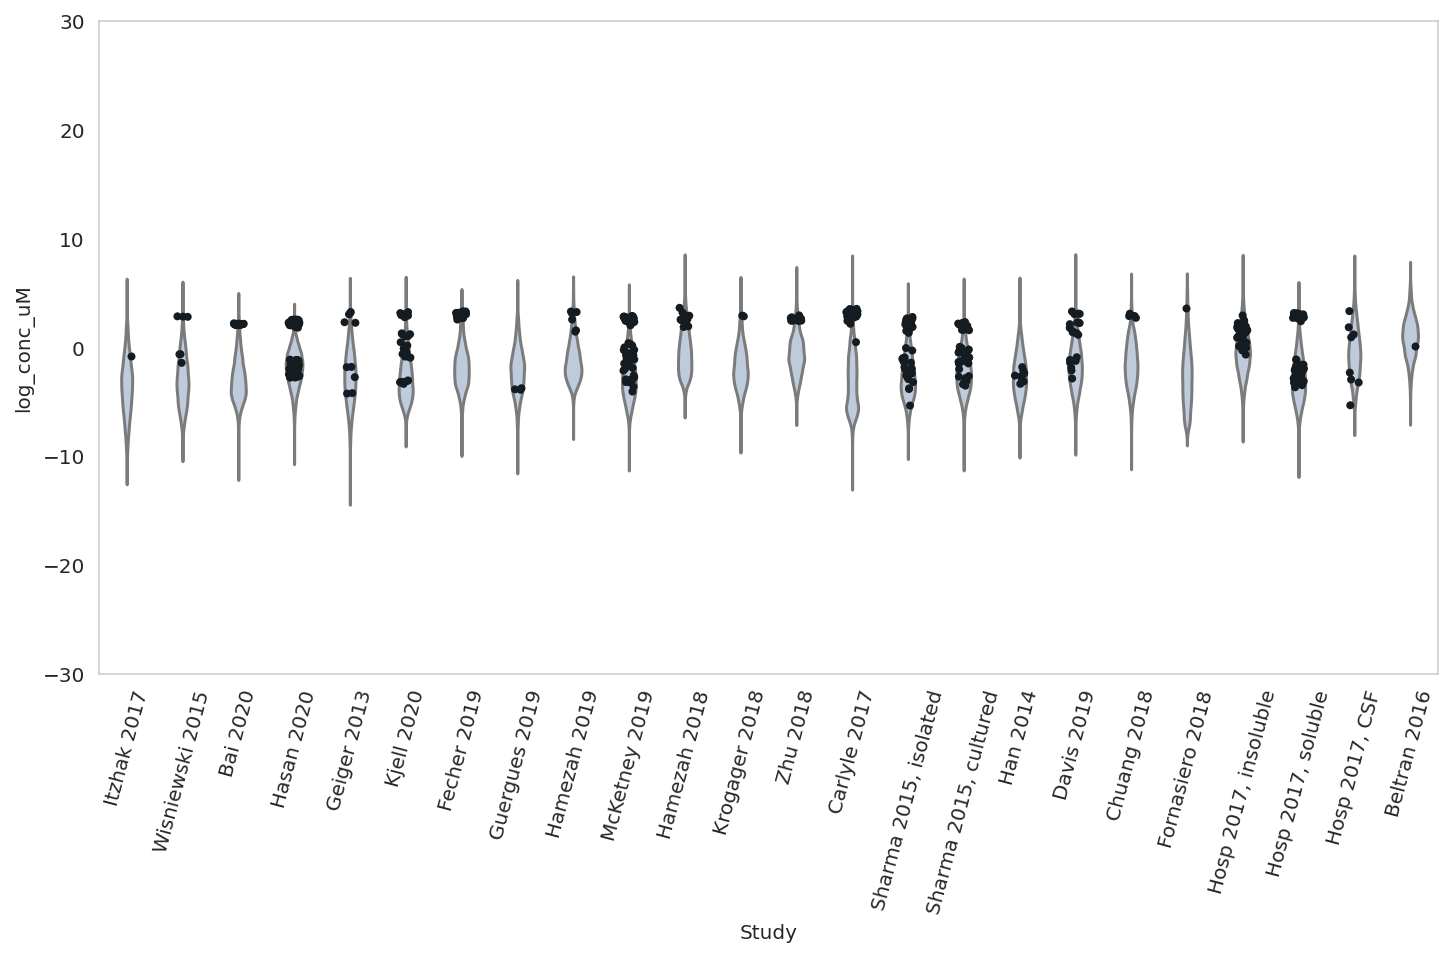

In [27]:
fig = plt.figure(figsize=(12, 6))

#after
ax = sns.violinplot(x="Study", y="log_conc_uM", data=df.loc[df['Study'].isin(df.loc[df['gene_id_final']=='STXBP1','Study'].unique())], 
                    inner=None,dodge=False, width=0.3,color='#b8cbe1', zorder=1 ) #, fliersize=2)

ax = sns.stripplot(x="Study", y="log_conc_uM", data=df.loc[df['Study'].isin((df.loc[df['gene_id_final']=='STXBP1','Study'].unique())) & (df['gene_id_final']=='STXBP1')],
                   alpha=1.0, size=4, color='#141c22', zorder=2)

ax.grid(False)
plt.xticks(rotation=75)
ax.set_ylabel('log_conc_uM')

plt.ylim([-30,30])

plt.show()

#fig.savefig('../plots/fig1dextra_violinsWithSTXBP1_ConcBeforeNormaliz_8july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1dextra_violinsWithSTXBP1_ConcBeforeNormaliz_8july2020.svg', bbox_inches='tight', transparent=True)

# fig 1 d extra -> supp

In [28]:
df.loc[df['Study']=='Hasan 2020','condition'].unique()

array(['control', 'EAE'], dtype=object)

In [29]:
df.loc[df['Study']=='Zhu 2018','condition'].unique()

array([nan], dtype=object)

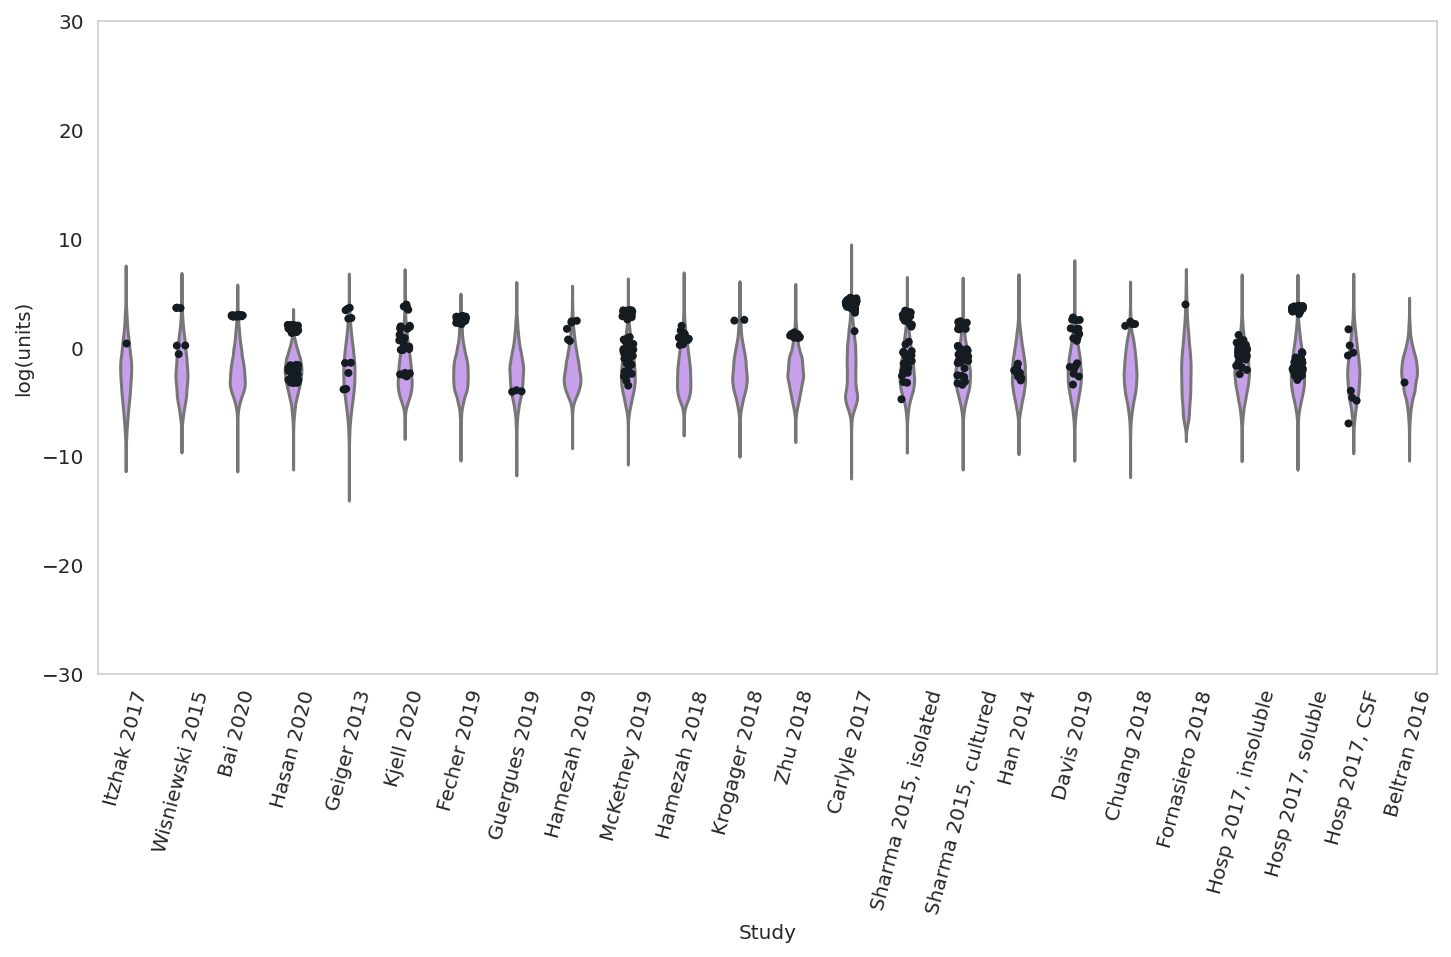

In [31]:
fig = plt.figure(figsize=(12, 6))

#after
ax = sns.violinplot(x="Study", y="log_conc_uM_medNorm", data=df.loc[df['Study'].isin(df.loc[df['gene_id_final']=='STXBP1','Study'].unique())], inner=None,dodge=False, width=0.3,color='#c892f7', zorder=1 ) #, fliersize=2)

ax = sns.stripplot(x="Study", y="log_conc_uM_medNorm", data=df.loc[df['Study'].isin((df.loc[df['gene_id_final']=='STXBP1','Study'].unique())) & (df['gene_id_final']=='STXBP1')],
                   alpha=1.0, size=4, color='#141c22', zorder=2)

ax.grid(False)
plt.xticks(rotation=75)
ax.set_ylabel('log(units)')


#ax.plot(1, 10, marker='o',color='#1dd400' )  # BASP1
#ax = ax.plot([0,1], [np.mean(df_sort.loc[df_sort['Gene names']=='BASP1','log conc uM median norm']),], \
#             marker='o',color='#1dd400', zorder=3 )  # BASP1


plt.ylim([-30,30])


plt.show()
#fig.savefig('../plots/fig1d_violinsWithSTXBP1_ConcAfterMedNormaliz_8july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1d_violinsWithSTXBP1_ConcAfterMedNormaliz_8july2020.svg', bbox_inches='tight', transparent=True)

# fig 1 d

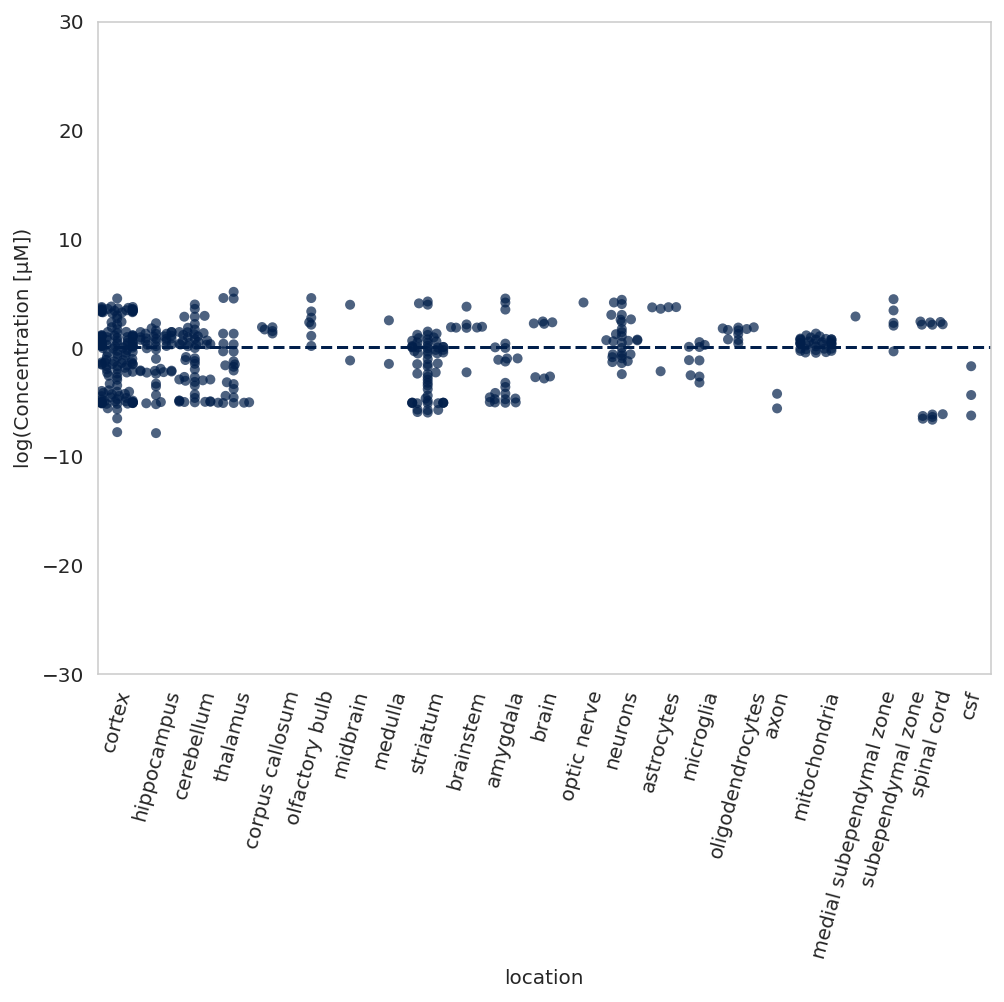

In [38]:
# GFAP
custom_dict_loc_GFAP = {'cortex':0,
                        'hippocampus':1,
                        'cerebellum':2,
                        'thalamus':3,
                        'corpus callosum':4,
                        'olfactory bulb':5,
                        'midbrain':6,
                        'medulla':7,
                        'striatum':8,
                        'brainstem':9,
                        'amygdala':10,
                        'brain':11,
                        'optic nerve':12,
                        'neurons':13,
                        'astrocytes':14, 
                        'microglia':15, 
                        'oligodendrocytes':16,
                        'axon':17,
                        'mitochondria':18,
                        'medial subependymal zone':19,
                        'subependymal zone':20,
                        'spinal cord':21,
                       'csf':22}

GFAP = df[df['gene_id_final']=='GFAP'].copy()

GFAP = GFAP.iloc[GFAP['location'].map(custom_dict_loc_GFAP).argsort()]

GFAP = GFAP.reset_index(drop=True)


fig = plt.figure(figsize=(8, 6))

ax = plt.axhline(y=np.median(GFAP["log_conc_uM_medNorm"]), color='#011f4b', linestyle="dashed")

ax = sns.swarmplot(x="location", y="log_conc_uM_medNorm", data=GFAP, alpha=0.7, size=5, color='#011f4b', order=list(custom_dict_loc_GFAP.keys()))

ax.grid(False)

plt.xticks(rotation=75)

ax.set_ylabel('log(Concentration [µM])')

plt.ylim([-30,30])

plt.show()

#fig.savefig('../plots/S1H_GFAP_normConc_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S1H_GFAP_normConc_28july2020.svg', transparent=True)

#supp fig

In [39]:
df.loc[df['gene_id_final']=='GAD1','location'].unique()

array(['brain', 'cortex', 'hippocampus', 'spinal cord', 'brainstem',
       'striatum', 'cerebellum', 'medulla', 'midbrain', 'olfactory bulb',
       'medial subependymal zone', 'subependymal zone', 'mitochondria',
       'amygdala', 'thalamus', 'neurons', 'oligodendrocytes',
       'astrocytes', 'microglia', 'corpus callosum', 'optic nerve',
       'axon'], dtype=object)

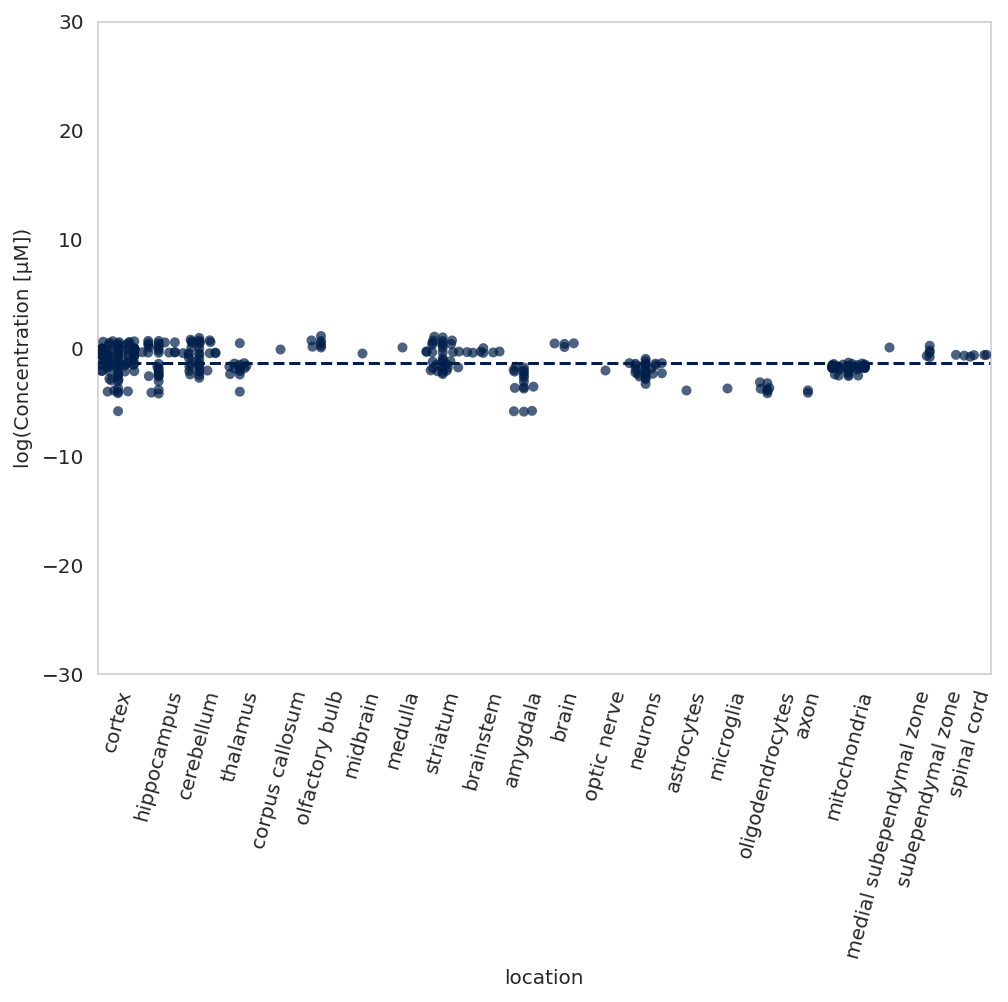

In [40]:
# GAD1
custom_dict_loc_GAD1 = {'cortex':0,
                        'hippocampus':1,
                        'cerebellum':2,
                        'thalamus':3,
                        'corpus callosum':4,
                        'olfactory bulb':5,
                        'midbrain':6,
                        'medulla':7,
                        'striatum':8,
                        'brainstem':9,
                        'amygdala':10,
                        'brain':11,
                        'optic nerve':12,
                        'neurons':13,
                        'astrocytes':14, 
                        'microglia':15, 
                        'oligodendrocytes':16,
                        'axon':17,
                        'mitochondria':18,
                        'medial subependymal zone':19,
                        'subependymal zone':20,
                        'spinal cord':21}

GAD1 = df[df['gene_id_final']=='GAD1'].copy()

GAD1 = GAD1.iloc[GAD1['location'].map(custom_dict_loc_GAD1).argsort()]

GAD1 = GAD1.reset_index(drop=True)


fig = plt.figure(figsize=(8, 6))

ax = plt.axhline(y=np.median(GAD1["log_conc_uM_medNorm"]), color='#011f4b', linestyle="dashed")

ax = sns.swarmplot(x="location", y="log_conc_uM_medNorm", data=GAD1, alpha=0.7, size=5, color='#011f4b', order=list(custom_dict_loc_GAD1.keys()))

ax.grid(False)

plt.xticks(rotation=75)

ax.set_ylabel('log(Concentration [µM])')

plt.ylim([-30,30])

plt.show()

#fig.savefig('../plots/S1H_GAD1_normConc_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S1H_GAD1_normConc_28july2020.svg', transparent=True)

#supp fig

In [41]:
df.loc[df['gene_id_final']=='UBAP1','location'].unique()

array(['subcellular not specified', 'cortex', 'cerebellum', 'spinal cord',
       'midbrain', 'olfactory bulb', 'subependymal zone',
       'medial subependymal zone', 'amygdala', 'striatum', 'thalamus',
       'hippocampus', 'optic nerve', 'astrocytes', 'microglia', 'neurons',
       'oligodendrocytes', 'brainstem', 'corpus callosum', 'brain',
       'axon'], dtype=object)

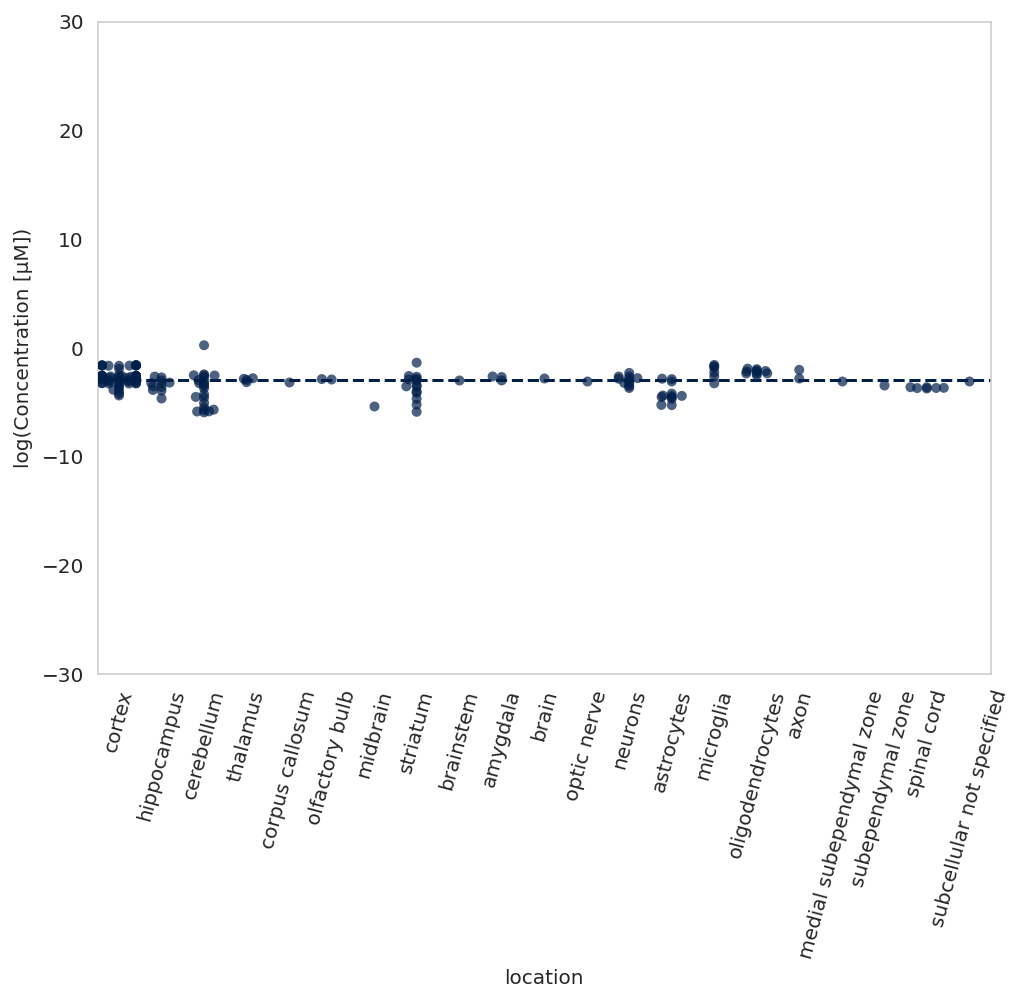

In [42]:
# UBAP1
custom_dict_loc_UBAP1 = {'cortex':0,
                        'hippocampus':1,
                        'cerebellum':2,
                        'thalamus':3,
                        'corpus callosum':4,
                        'olfactory bulb':5,
                        'midbrain':6,
                        'striatum':7,
                        'brainstem':8,
                        'amygdala':9,
                        'brain':10,
                        'optic nerve':11,
                        'neurons':12,
                        'astrocytes':13, 
                        'microglia':14, 
                        'oligodendrocytes':15,
                        'axon':16,
                        'medial subependymal zone':17,
                        'subependymal zone':18,
                        'spinal cord':19,
                        'subcellular not specified':20}

UBAP1 = df[df['gene_id_final']=='UBAP1'].copy()

UBAP1 = UBAP1.iloc[UBAP1['location'].map(custom_dict_loc_UBAP1).argsort()]

UBAP1 = UBAP1.reset_index(drop=True)


fig = plt.figure(figsize=(8, 6))

ax = plt.axhline(y=np.median(UBAP1["log_conc_uM_medNorm"]), color='#011f4b', linestyle="dashed")

ax = sns.swarmplot(x="location", y="log_conc_uM_medNorm", data=UBAP1, alpha=0.7, size=5, color='#011f4b', order=list(custom_dict_loc_UBAP1.keys()))

ax.grid(False)

plt.xticks(rotation=75)

ax.set_ylabel('log(Concentration [µM])')

plt.ylim([-30,30])

plt.show()

#fig.savefig('../plots/S1I_UBAP1_normConc_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S1I_UBAP1_normConc_28july2020.svg', transparent=True)

# supp fig

In [17]:
#find genes with the highest number of datasets reporting them
genesInStudiesNum = df[['gene_id_final','Study']].groupby('gene_id_final').nunique()

print(len(genesInStudiesNum[genesInStudiesNum['Study']==np.max(genesInStudiesNum['Study'])]))

genesInStudiesNumMax = genesInStudiesNum[genesInStudiesNum['Study']==np.max(genesInStudiesNum['Study'])]
genesInStudiesNumMax = genesInStudiesNumMax.drop(columns='gene_id_final')
genesInStudiesNumMax = genesInStudiesNumMax.reset_index()


74


In [18]:
np.max(genesInStudiesNum['Study'])

24

In [19]:
genesInStudiesNumMax_dfg = df[df['gene_id_final'].isin(genesInStudiesNumMax['gene_id_final'].values)]
genesInStudiesNumMax_dfg = genesInStudiesNumMax_dfg.reset_index(drop=True)
genesInStudiesNumMax_dfg.head()

gene_names                       Uniprot        Study Organism  \
0      PDIA3                        P27773  Itzhak 2017    mouse   
1       IDH1  O88844;A0A087WPT4;A0A087WRS9  Itzhak 2017    mouse   
2       CCT4          P80315;Q564F4;G5E839  Itzhak 2017    mouse   
3       CCT2                 P80314;Q542X7  Itzhak 2017    mouse   
4      MAPK1                        P63085  Itzhak 2017    mouse   

                location Age_cat Age_days condition sample_id  \
0                     er    embr       15       NaN       NaN   
1  large protein complex    embr       15       NaN       NaN   
2  large protein complex    embr       15       NaN       NaN   
3  large protein complex    embr       15       NaN       NaN   
4  large protein complex    embr       15       NaN       NaN   

  molecular_weight_kDa     raw_data                      raw_data_units  \
0               56.678  8101.607562  Median cellular concentration [nM]   
1               46.674  6994.124953  Median cellular concentration [nM]   
2               58.066  5114.650085  Median cellular concentration [nM]   
3               57.477  6555.905915  Median cellular concentration [nM]   
4               41.275  2039.842799  Median cellular concentration [nM]   

  gene_name_unified Uniprot_unified gene_id_final  log_raw_data  \
0             PDIA3          P27773         PDIA3      8.999818   
1              IDH1          O88844          IDH1      8.852826   
2              CCT4          P80315          CCT4      8.539864   
3              CCT2          P80314          CCT2      8.788122   
4             MAPK1          P63085         MAPK1      7.620628   

            uniprot_from_gn Uniprot_final TheorPepNum  conc_uM  log_conc_uM  \
0  [P27773, P30101, P11598]        P27773        None  8.10161     2.092063   
1  [O75874, O88844, P41562]        O88844        None  6.99412     1.945071   
2  [P50991, P80315, Q7TPB1]        P80315        None  5.11465     1.632109   
3  [Q5XIM9, P78371, P80314]        P80314        None  6.55591     1.880366   
4  [P63086, P28482, P63085]        P63085        None  2.03984     0.712873   

  copyNum totalProtein totalVolume  \
0    None         None        None   
1    None         None        None   
2    None         None        None   
3    None         None        None   
4    None         None        None   

                                      sample_full_id compound_gene_protein_id  \
0                    Itzhak 2017_mouse_er_15_nan_nan             PDIA3#P27773   
1  Itzhak 2017_mouse_large protein complex_15_nan...              IDH1#O88844   
2  Itzhak 2017_mouse_large protein complex_15_nan...              CCT4#P80315   
3  Itzhak 2017_mouse_large protein complex_15_nan...              CCT2#P80314   
4  Itzhak 2017_mouse_large protein complex_15_nan...             MAPK1#P63085   

                                              row_id  \
0       PDIA3#P27773@Itzhak 2017_mouse_er_15_nan_nan   
1  IDH1#O88844@Itzhak 2017_mouse_large protein co...   
2  CCT4#P80315@Itzhak 2017_mouse_large protein co...   
3  CCT2#P80314@Itzhak 2017_mouse_large protein co...   
4  MAPK1#P63085@Itzhak 2017_mouse_large protein c...   

                                         row_gene_id gene_id_dd  \
0              PDIA3@Itzhak 2017_mouse_er_15_nan_nan       None   
1  IDH1@Itzhak 2017_mouse_large protein complex_1...       None   
2  CCT4@Itzhak 2017_mouse_large protein complex_1...       None   
3  CCT2@Itzhak 2017_mouse_large protein complex_1...       None   
4  MAPK1@Itzhak 2017_mouse_large protein complex_...       None   

   log_conc_uM_medNorm  
0             3.299222  
1             3.152230  
2             2.839268  
3             3.087526  
4             1.920032

In [20]:
len(genesInStudiesNumMax_dfg)

31213

In [21]:
genesInStudiesNumMax_dfg_before = genesInStudiesNumMax_dfg[['gene_id_final','log_raw_data', 'raw_data_units']].copy()
genesInStudiesNumMax_dfg_after = genesInStudiesNumMax_dfg[['gene_id_final','log_conc_uM_medNorm', 'raw_data_units']].copy()

genesInStudiesNumMax_dfg_before = genesInStudiesNumMax_dfg_before.reset_index(drop=True)
genesInStudiesNumMax_dfg_after = genesInStudiesNumMax_dfg_after.reset_index(drop=True)

genesInStudiesNumMax_dfg_before['before_after'] = 'before'
genesInStudiesNumMax_dfg_after['before_after'] = 'after'
genesInStudiesNumMax_dfg_after['raw_data_units'] = 'processed' #neededd only for some plots

genesInStudiesNumMax_dfg_before = genesInStudiesNumMax_dfg_before.rename(columns={'log_raw_data':'levels'})
genesInStudiesNumMax_dfg_after = genesInStudiesNumMax_dfg_after.rename(columns={'log_conc_uM_medNorm':'levels'})

genesInStudiesNumMax_dfg_ba = pd.concat([genesInStudiesNumMax_dfg_before,genesInStudiesNumMax_dfg_after],ignore_index=True,sort=True)

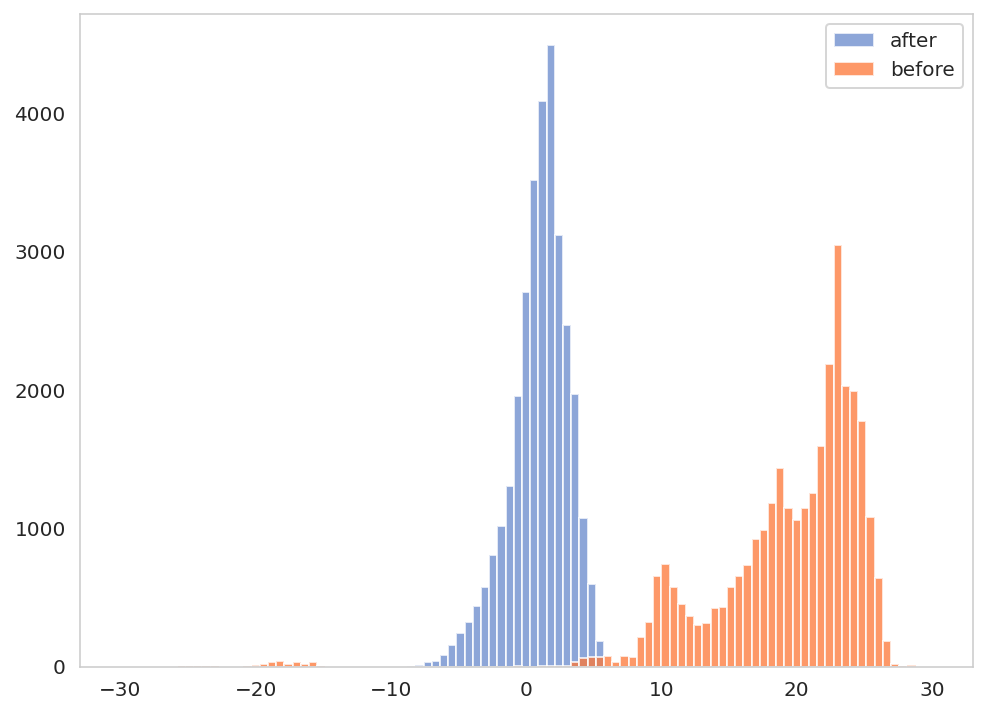

In [48]:
fig = plt.figure(figsize=(8, 6))

bins = np.linspace(-30, 30, 100)

plt.hist(genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['before_after']=='after','levels'], bins, alpha=0.75, label='after',color='#6789cc')
plt.hist(genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['before_after']=='before','levels'], bins, alpha=0.75, label='before',color='#fd7636') # bins, 

plt.grid(False)

plt.legend(loc='upper right')
plt.show()


#fig.savefig('../plots/extra_hist_levels_ba_normalized_vert_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/extra_hist_levels_ba_normalized_vert_28july2020.svg', transparent=True)

# extra fig; not needed anymore; see similar figure below

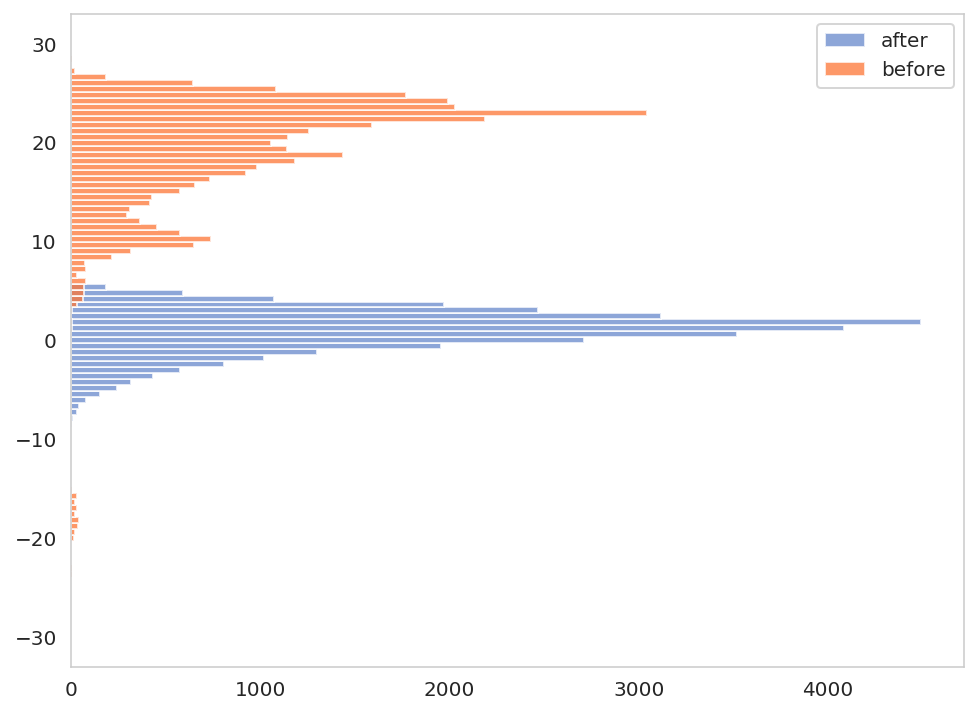

In [49]:
fig = plt.figure(figsize=(8, 6))

bins = np.linspace(-30, 30, 100)

plt.hist(genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['before_after']=='after','levels'], bins, alpha=0.75, label='after', orientation="horizontal",color='#6789cc')
plt.hist(genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['before_after']=='before','levels'], bins, alpha=0.75, label='before', orientation="horizontal",color='#fd7636') # bins, 

plt.grid(False)

plt.legend(loc='upper right')
plt.show()


#fig.savefig('../plots/fig1h_hist_levels_ba_normalized_horiz_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1h_hist_levels_ba_normalized_horiz_28july2020.svg', transparent=True)

# fig 1 h

In [23]:
len(genesInStudiesNumMax_dfg_ba['gene_id_final'].unique())

74

In [24]:
genesInStudiesNumMax_dfg_ba['levels_exp_scale'] = np.exp(genesInStudiesNumMax_dfg_ba['levels'].values.astype(float))

In [25]:
genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['raw_data_units'].isin(['Protein concentration (mol/g protein)','Mean concentration [mol/(g total protein)]']),'raw_data_units'] = 'mol/g protein'


In [26]:
genesInStudiesNumMax_dfg_ba['raw_data_units'].unique()

array(['Median cellular concentration [nM]', 'mol/g protein',
       'tmt abundance', 'IntensityL', 'LFQintensity', 'iBAQ', 'processed'],
      dtype=object)

In [27]:
genesInStudiesNumMax_dfg_ba_groups = genesInStudiesNumMax_dfg_ba.groupby(['gene_id_final', 'before_after', 'raw_data_units'], as_index=False)

variabilityScore_per_groups = genesInStudiesNumMax_dfg_ba_groups.aggregate(variability_score)

In [28]:
variabilityScore_per_groups.head()

gene_id_final before_after                      raw_data_units    levels  \
0         ACAT1        after                           processed  0.005495   
1         ACAT1       before                          IntensityL  0.010091   
2         ACAT1       before                        LFQintensity  0.000494   
3         ACAT1       before  Median cellular concentration [nM]  0.000000   
4         ACAT1       before                                iBAQ  0.001914   

   levels_exp_scale  
0          0.001887  
1          0.175827  
2          0.004468  
3          0.000000  
4          0.012966

In [29]:
variabilityScore_per_groups.columns

Index(['gene_id_final', 'before_after', 'raw_data_units', 'levels',
       'levels_exp_scale'],
      dtype='object')

In [30]:
chart = alt.Chart(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0],
         width=300,
         height=600
         ).mark_point(size=50).encode(
    x=alt.X('levels_exp_scale:Q', title = 'units of levels',scale=alt.Scale(type='log')),
    y=alt.Y('gene_id_final:N', title=None),
    color=alt.Color('before_after:N',legend=alt.Legend(title="before and after")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)


#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_4aug2020.html')  # .mark_point(size=30).encode(
#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_24jan2020.html') # .mark_point(size=50).encode( #marker size changed on 24jan2021

# fig 1 g

In [36]:
#only for variability score per group 
genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['raw_data_units'].isin(['tmt abundance', 'IntensityL', 'LFQintensity']),'raw_data_units'] = 'LFQTMTSILAC'


genesInStudiesNumMax_dfg_ba_groups = genesInStudiesNumMax_dfg_ba.groupby(['gene_id_final', 'before_after', 'raw_data_units'], as_index=False)

variabilityScore_per_groups = genesInStudiesNumMax_dfg_ba_groups.aggregate(variability_score)


variabilityScore_per_groups.loc[variabilityScore_per_groups['levels_exp_scale']!=0,'raw_data_units'].unique()

array(['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein',
       'Median cellular concentration [nM]'], dtype=object)

In [39]:
domain = ['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein','Median cellular concentration [nM]']
range_ = ['#6789cc', '#feba9a', '#fd834a','#ca5e2b','#652f15']

#logscaled x axis just to show in a more beautiful way

chart = alt.Chart(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0],
         width=300,
         height=600
         ).mark_point(size=50).encode(
    x=alt.X('levels_exp_scale:Q', title = 'units of levels',scale=alt.Scale(type='log')),
    y=alt.Y('gene_id_final:N', title=None),
    color=alt.Color('raw_data_units:N',scale=alt.Scale(domain=domain, range=range_),legend=alt.Legend(title="raw_data_units")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)


#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_4aug2020.html')  # .mark_point(size=30).encode(
#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_25jan2020.html') #new color scheme

# fig 1 g

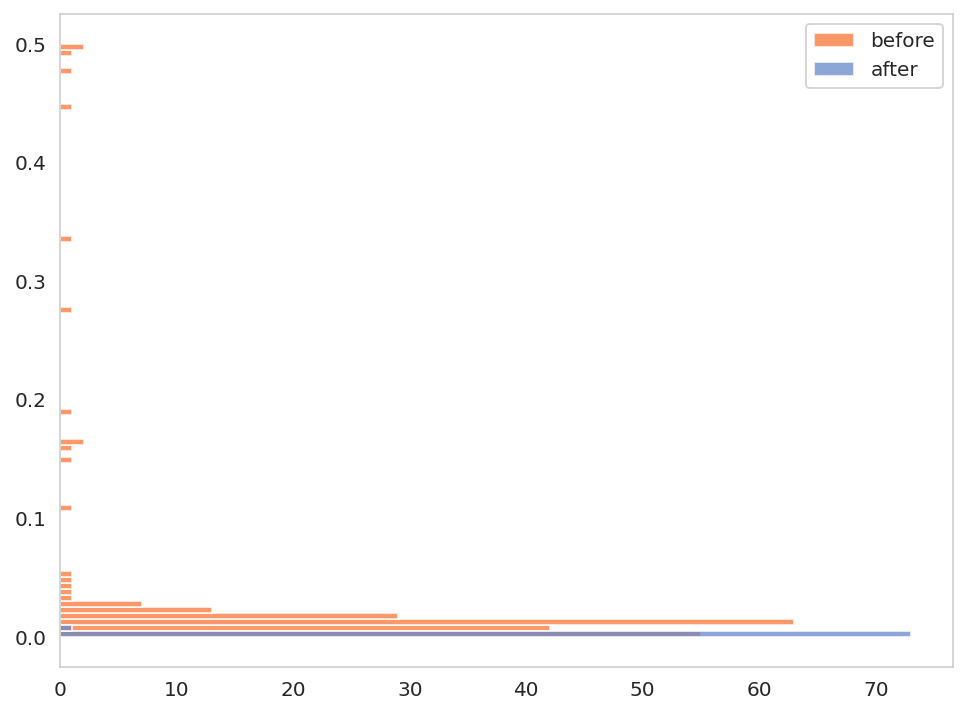

In [81]:
fig = plt.figure(figsize=(8, 6))

bins = np.linspace(0, 0.5, 100)

plt.hist(variabilityScore_per_groups.loc[(variabilityScore_per_groups['levels_exp_scale']!=0)&\
                                         (variabilityScore_per_groups['before_after']=='before'),'levels_exp_scale'], \
         bins,alpha=0.75, label='before', orientation="horizontal",color='#fd7636') # bins, 

plt.hist(variabilityScore_per_groups.loc[(variabilityScore_per_groups['levels_exp_scale']!=0)&\
                                         (variabilityScore_per_groups['before_after']=='after'),'levels_exp_scale'], \
         bins,alpha=0.75, label='after', orientation="horizontal",color='#6789cc')


plt.grid(False)

plt.legend(loc='upper right')
plt.show()

#fig.savefig('../plots/fig1i_variabilityScore_per_groups_CVnorm_4aug2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1i_variabilityScore_per_groups_CVnorm_4aug2020.svg', transparent=True)

# fig 1 i

In [33]:
#before
chart = alt.Chart(genesInStudiesNumMax_dfg_ba[genesInStudiesNumMax_dfg_ba['before_after']=='before'],
         width=250,
         height=600
         ).mark_point(size=25).encode(
    x=alt.X('levels:Q', title = 'units of levels',scale=alt.Scale(domain=(-30, 30))),
    y=alt.Y('gene_id_final:N', title=None),
    #color=alt.Color('before_after:N',legend=alt.Legend(title="before and after")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_mark(
    opacity=0.9,
    color='#fd7636'
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)

#chart.save('../plots/fig1e_levels_altair_4aug2020_before.html')  #).mark_point(size=5).encode(
#chart.save('../plots/fig1e_levels_altair_4aug2020_before.html') #).mark_point(size=15).encode(  # ).mark_point(size=50).encode(  #).mark_point(size=25).encode(


In [43]:
genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['before_after']=='before','raw_data_units'].unique()

array(['Median cellular concentration [nM]', 'mol/g protein',
       'LFQTMTSILAC', 'iBAQ'], dtype=object)

In [80]:
domain = ['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein','Median cellular concentration [nM]']
range_ = ['#6789cc', '#feba9a', '#fd834a','#ca5e2b','#652f15']

chart = alt.Chart(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0],
         width=300,
         height=600
         ).mark_point(size=50).encode(
    x=alt.X('levels_exp_scale:Q', title = 'units of levels',scale=alt.Scale(type='log')),
    y=alt.Y('gene_id_final:N', title=None),
    color=alt.Color('raw_data_units:N',scale=alt.Scale(domain=domain, range=range_),legend=alt.Legend(title="raw_data_units")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)


#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_4aug2020.html')  # .mark_point(size=30).encode(
#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_25jan2020.html') #new color scheme

# fig 1 g

In [100]:
domain = ['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein','Median cellular concentration [nM]']
range_ = ['#6789cc', '#fd7636', '#f7de52','#e7231e','#ac0026']
rangeShapes = ["circle","cross","diamond","triangle-up","square"]

chart = alt.Chart(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0],
         width=270,
         height=600
         ).mark_point(size=120,filled=True).encode(
    x=alt.X('levels_exp_scale:Q', title = 'units of levels',scale=alt.Scale(type='log')),
    y=alt.Y('gene_id_final:N', title=None),
    color=alt.Color('raw_data_units:N',scale=alt.Scale(domain=domain, range=range_),legend=alt.Legend(title="raw_data_units")),
    shape=alt.Shape('raw_data_units:N',scale=alt.Scale(domain=domain, range=rangeShapes),legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)

#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_4aug2020.html')  # .mark_point(size=30).encode(
#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair2_25jan2020.html') #new color scheme


In [104]:

domain = ['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein','Median cellular concentration [nM]']
range_ = ['#6789cc', '#fd7636', '#f7de52','#e7231e','#ac0026']
#rangeShapes = ['o','X','d','^','*']
rangeShapes = ["circle","cross","diamond","triangle-up","square"]


chart = alt.Chart(variabilityScore_per_groups,
         width=270,
         height=600
         ).mark_point(size=120,filled=True).encode(
    x=alt.X('levels_exp_scale:Q', title = 'units of levels',scale=alt.Scale(type='log')),
    y=alt.Y('gene_id_final:N', title=None),
    color=alt.Color('raw_data_units:N',scale=alt.Scale(domain=domain, range=range_),legend=alt.Legend(title="raw_data_units")),
    shape=alt.Shape('raw_data_units:N',scale=alt.Scale(domain=domain, range=rangeShapes),legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)

#chart.save('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_altair_4aug2020.html')  # .mark_point(size=30).encode(
chart.save('../plots/withZeroesfig1g_variabilityScore_per_groups_CVnorm_scatter_altair2_25jan2020.html') #new color scheme


In [109]:
variabilityScore_per_groups[(variabilityScore_per_groups['gene_id_final']=='ACAT1')].head(10)

gene_id_final before_after                      raw_data_units    levels  \
0         ACAT1        after                           processed  0.005495   
1         ACAT1       before                         LFQTMTSILAC  0.000659   
2         ACAT1       before  Median cellular concentration [nM]  0.000000   
3         ACAT1       before                                iBAQ  0.001914   
4         ACAT1       before                       mol/g protein  0.000311   

   levels_exp_scale  
0          0.001887  
1          0.004241  
2          0.000000  
3          0.012966  
4          0.005460

In [105]:
len(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']==0])

69

In [106]:
len(variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0])

301

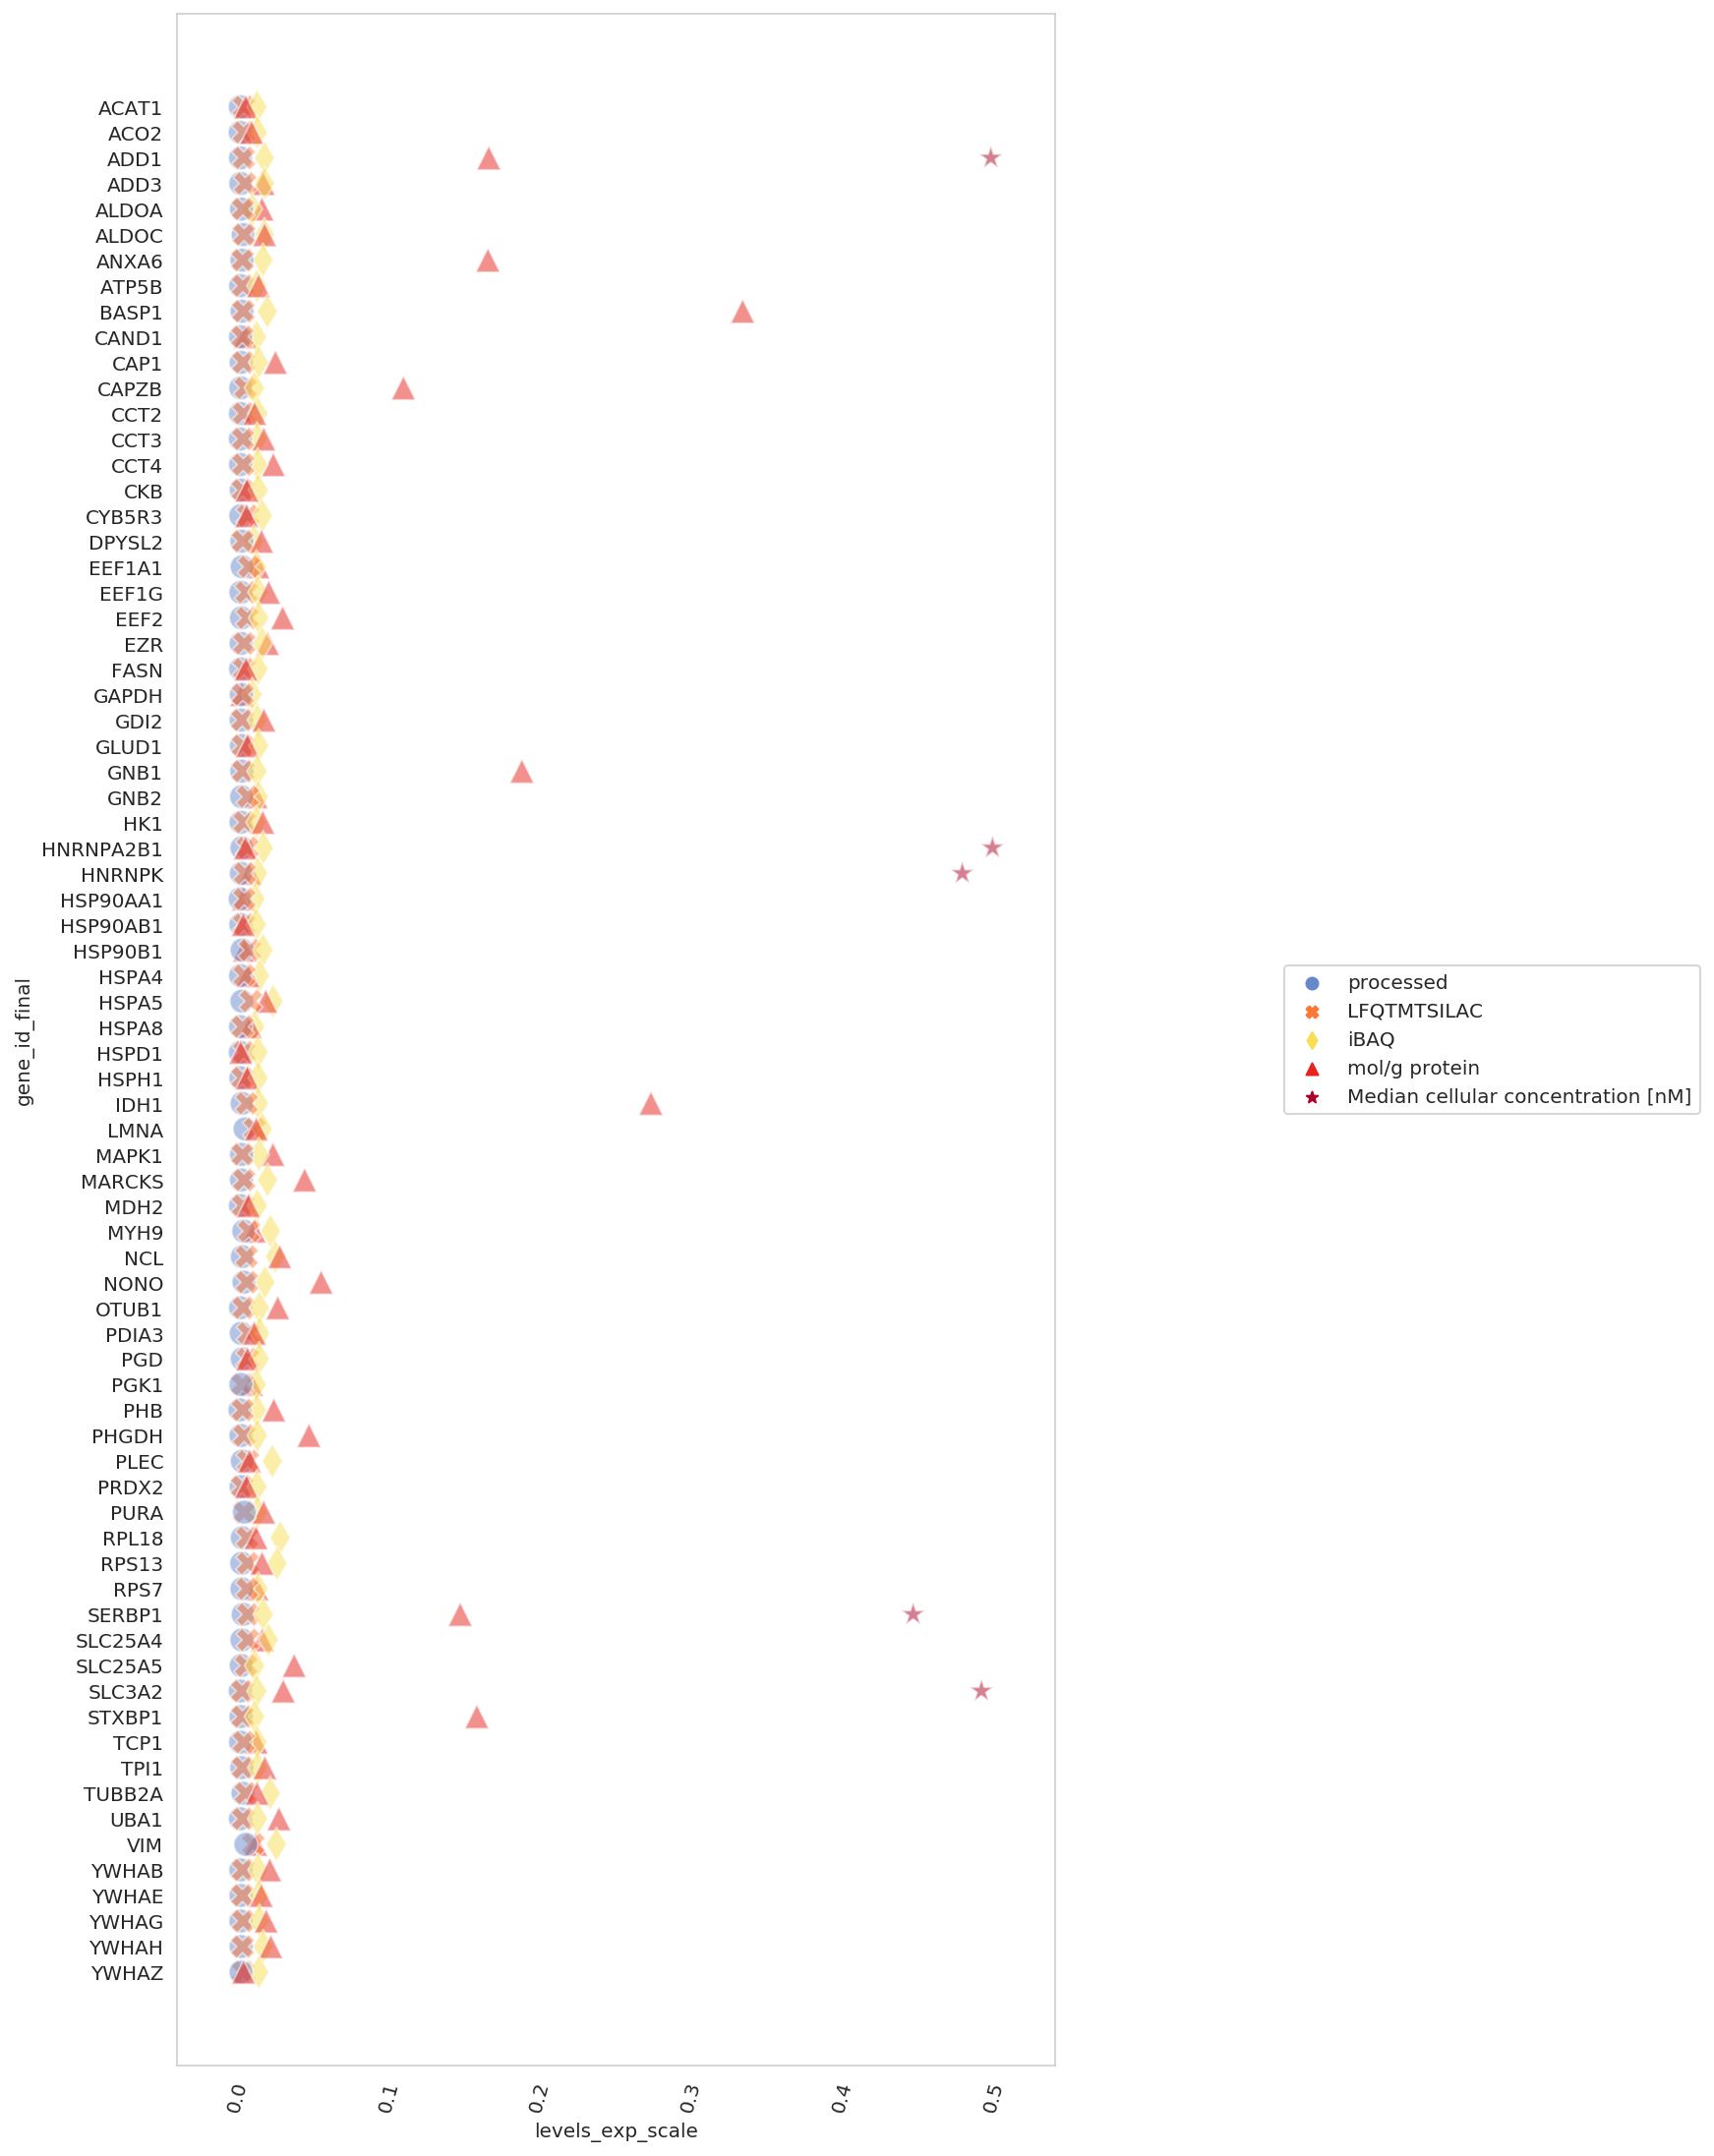

In [79]:
my_pal = {'processed':'#6789cc',
                  'LFQTMTSILAC':'#fd7636',
                  'iBAQ': '#f7de52',
                  'mol/g protein': '#e7231e',
                   'Median cellular concentration [nM]': '#ac0026'}
          
    
my_markers = {'processed':'o',
                  'LFQTMTSILAC':'X',
                  'iBAQ': 'd',
                  'mol/g protein': '^',
                   'Median cellular concentration [nM]': '*'}

fig = plt.figure(figsize=(8, 19.2))

ax = sns.scatterplot(data=variabilityScore_per_groups[variabilityScore_per_groups['levels_exp_scale']!=0].sort_values('gene_id_final'),
                x="levels_exp_scale", y="gene_id_final",s=150,
                hue="raw_data_units",palette=my_pal, style="raw_data_units", markers = my_markers, alpha=0.5)


plt.xticks(rotation=75)

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.show()

#fig.savefig('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_new_25jan2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1g_variabilityScore_per_groups_CVnorm_scatter_new_25jan2020.svg', bbox_inches='tight', transparent=True)

# fig 1 g


In [46]:
domain = ['processed', 'LFQTMTSILAC', 'iBAQ', 'mol/g protein','Median cellular concentration [nM]']
range_ = ['#6789cc', '#feba9a', '#fd834a','#ca5e2b','#652f15']

#before
chart = alt.Chart(genesInStudiesNumMax_dfg_ba[genesInStudiesNumMax_dfg_ba['before_after']=='before'],
         width=250,
         height=600
         ).mark_point(size=50,strokeWidth=0.75).encode(
    x=alt.X('levels:Q', title = 'units of levels',scale=alt.Scale(domain=(-30, 30))),
    y=alt.Y('gene_id_final:N', title=None),
    opacity=alt.value(0.5),
    color=alt.Color('raw_data_units:N',scale=alt.Scale(domain=domain, range=range_),legend=alt.Legend(title="raw_data_units")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)

#chart.save('../plots/fig1e_levels_altair_4aug2020_before.html')  #).mark_point(size=5).encode(
chart.save('../plots/fig1e_levels_altair_25jan2021_before.html') #).mark_point(size=15).encode(  # ).mark_point(size=50).encode(  #).mark_point(size=25).encode(


In [47]:
genesInStudiesNumMax_dfg_ba.head()

before_after gene_id_final    levels                      raw_data_units  \
0       before         PDIA3  8.999818  Median cellular concentration [nM]   
1       before          IDH1  8.852826  Median cellular concentration [nM]   
2       before          CCT4  8.539864  Median cellular concentration [nM]   
3       before          CCT2  8.788122  Median cellular concentration [nM]   
4       before         MAPK1  7.620628  Median cellular concentration [nM]   

   levels_exp_scale  
0       8101.607562  
1       6994.124953  
2       5114.650085  
3       6555.905915  
4       2039.842799

In [ ]:
#my_pal = {'LFQintensity':'#feb54f','IntensityL':'#fd7636', 'Median cellular concentration [nM]':'#ac0026', 'iBAQ':'#f7de52', 
#          'Protein concentration (mol/g protein)':'#e7231e','Mean concentration [mol/(g total protein)]':'#e7231e','tmt abundance':'#fd7636'}


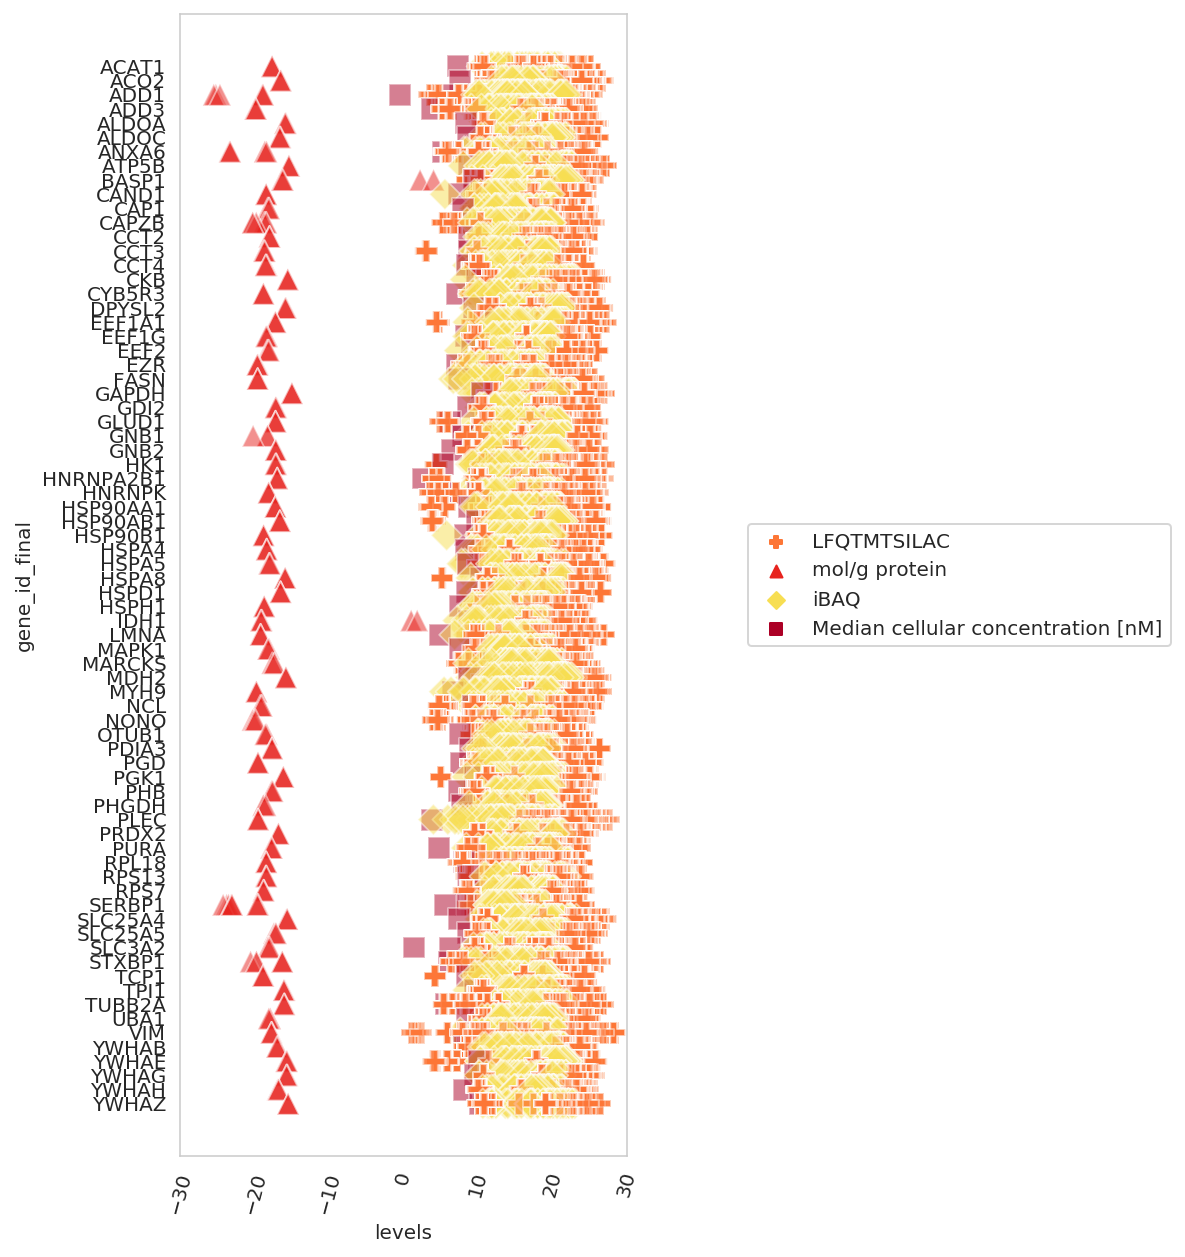

In [103]:

my_pal = {'processed':'#6789cc',
                  'LFQTMTSILAC':'#fd7636',
                  'iBAQ': '#f7de52',
                  'mol/g protein': '#e7231e',
                   'Median cellular concentration [nM]': '#ac0026'}
          
    
my_markers = {'processed':'o',
                  'LFQTMTSILAC':'P',
                  'iBAQ': 'D',
                  'mol/g protein': '^',
                   'Median cellular concentration [nM]': 's'}

#rangeShapes = ['o','X','d','^','*']
#rangeShapes = ["circle","cross","diamond","triangle-up","square"]


#fig = plt.figure(figsize=(8/2, 19.2/2))
fig = plt.figure(figsize=(8/2, 21/2))


ax = sns.scatterplot(data=genesInStudiesNumMax_dfg_ba[genesInStudiesNumMax_dfg_ba['before_after']=='before'].sort_values('gene_id_final'),
                x="levels", y="gene_id_final",s=120,
                hue="raw_data_units",palette=my_pal, style="raw_data_units", markers = my_markers, alpha=0.5)

ax.grid(False)
plt.xticks(rotation=75)
#ax.set_ylabel('proteins')

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.xlim([-30,30])

plt.show()

fig.savefig('../plots/fig1e_levels_sns_25jan2021_before.png', dpi=300, bbox_inches='tight', transparent=True)
fig.savefig('../plots/fig1e_levels_sns_25jan2021_before.svg', bbox_inches='tight', transparent=True)


In [34]:
#after
chart = alt.Chart(genesInStudiesNumMax_dfg_ba[genesInStudiesNumMax_dfg_ba['before_after']=='after'],
         width=250,
         height=600
         ).mark_point(size=25).encode(
    x=alt.X('levels:Q', title = 'units of levels',scale=alt.Scale(domain=(-30, 30))),
    y=alt.Y('gene_id_final:N', title=None),
    #color=alt.Color('before_after:N',legend=alt.Legend(title="before and after")),
    shape=alt.Shape('raw_data_units:N',legend=alt.Legend(title="raw_data_units"))
).configure_mark(
    opacity=0.9,
    color='#6789cc'
).configure_axis(labelFontSize=8,titleFontSize=10,tickSize=8).configure_legend(labelFontSize=8,titleFontSize=10)

#chart.save('../plots/fig1f_levels_altair_4aug2020_after.html')
chart.save('../plots/fig1f_levels_altair_4aug2020_after.html')


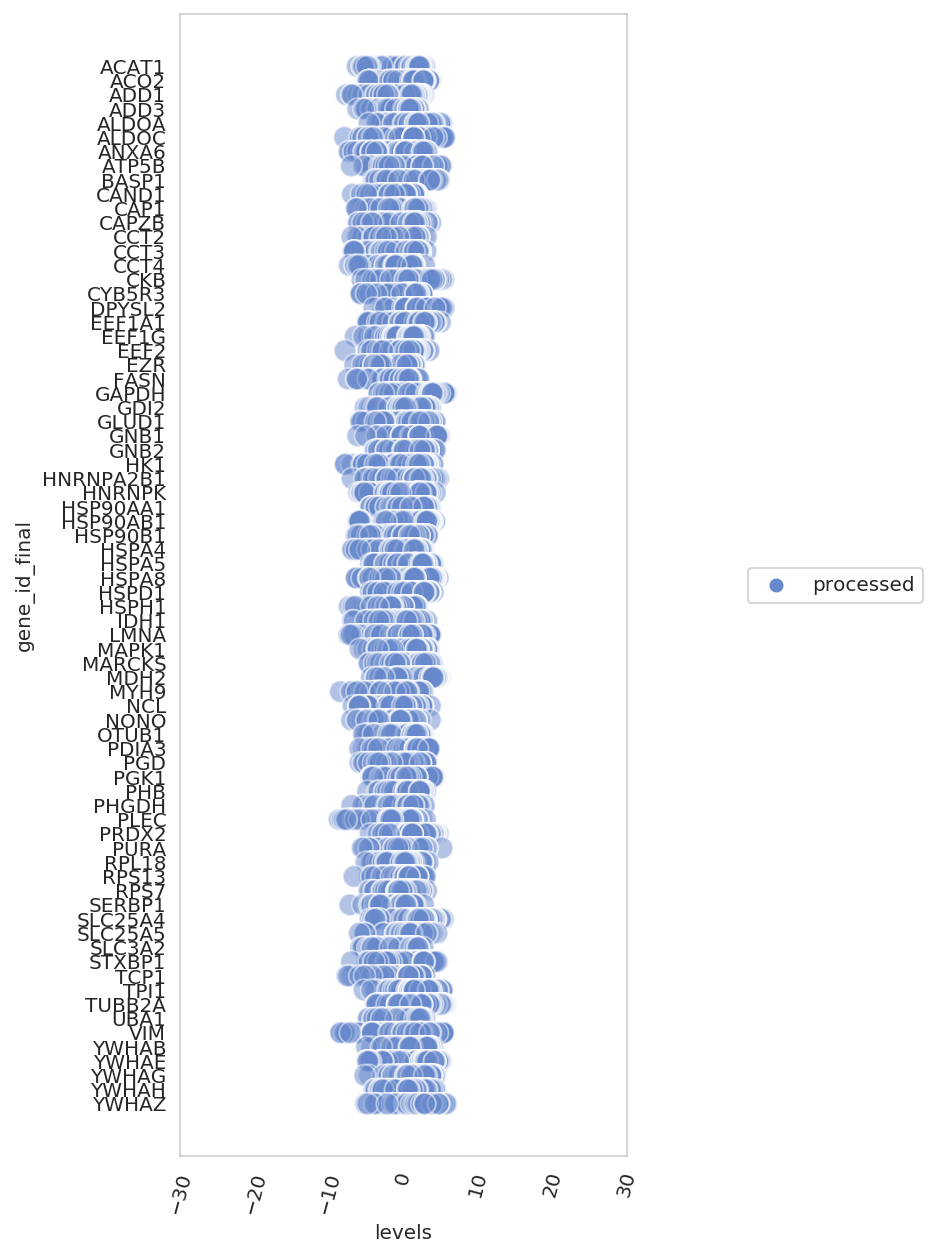

In [102]:
my_pal = {'processed':'#6789cc',
                  'LFQTMTSILAC':'#fd7636',
                  'iBAQ': '#f7de52',
                  'mol/g protein': '#e7231e',
                   'Median cellular concentration [nM]': '#ac0026'}
          
    
my_markers = {'processed':'o',
                  'LFQTMTSILAC':'P',
                  'iBAQ': 'D',
                  'mol/g protein': '^',
                   'Median cellular concentration [nM]': 's'}

fig = plt.figure(figsize=(8/2, 21/2))


ax = sns.scatterplot(data=genesInStudiesNumMax_dfg_ba[genesInStudiesNumMax_dfg_ba['before_after']=='after'].sort_values('gene_id_final'),
                x="levels", y="gene_id_final",s=120,
                hue="raw_data_units",palette=my_pal, style="raw_data_units", markers = my_markers, alpha=0.5)

ax.grid(False)
plt.xticks(rotation=75)

ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.xlim([-30,30])

plt.show()

#fig.savefig('../plots/fig1f_levels_sns_25jan2021_after.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/fig1f_levels_sns_25jan2021_after.svg', bbox_inches='tight', transparent=True)


In [86]:
genesInStudiesNumMax_dfg_ba.columns

Index(['before_after', 'gene_id_final', 'levels', 'raw_data_units',
       'levels_exp_scale'],
      dtype='object')

In [62]:
#genesInStudiesNumMax_dfg_ba = genesInStudiesNumMax_dfg_ba.drop(columns='levels_exp_scale')

In [32]:
#only for variability score per group 
genesInStudiesNumMax_dfg_ba.loc[genesInStudiesNumMax_dfg_ba['raw_data_units'].isin(['tmt abundance', 'IntensityL', 'LFQintensity']),'raw_data_units'] = 'LFQTMTSILAC'


genesInStudiesNumMax_dfg_ba_groups = genesInStudiesNumMax_dfg_ba.groupby(['gene_id_final', 'before_after', 'raw_data_units'], as_index=False)

variabilityScore_per_groups = genesInStudiesNumMax_dfg_ba_groups.aggregate(variability_score)

In [33]:
len(variabilityScore_per_groups)

370

In [34]:
variabilityScore_per_groups.loc[(variabilityScore_per_groups['gene_id_final']=='STXBP1') & \
                                (variabilityScore_per_groups['before_after']=='after')].head()

gene_id_final before_after raw_data_units    levels  levels_exp_scale
315        STXBP1        after      processed  0.004222          0.002356

In [35]:
variabilityScore_per_groups.loc[(variabilityScore_per_groups['gene_id_final']=='STXBP1') & \
                                (variabilityScore_per_groups['before_after']=='before')].head(20)

gene_id_final before_after                      raw_data_units    levels  \
316        STXBP1       before                         LFQTMTSILAC  0.000635   
317        STXBP1       before  Median cellular concentration [nM]  0.000000   
318        STXBP1       before                                iBAQ  0.001267   
319        STXBP1       before                       mol/g protein  0.017266   

     levels_exp_scale  
316          0.003348  
317          0.000000  
318          0.011332  
319          0.158405

In [ ]:
with open('../data/6_df_sort.pkl','rb') as f:
    df_sort = pkl.load(f)

In [18]:
len(df.loc[df['log_conc_uM_medNorm'].isna()]) 

0

In [19]:
len(df.loc[df['log_conc_uM_medNorm'].isna()]) 

0

In [20]:
len(df.loc[df['log_conc_uM'].isna()])

0

In [29]:
dfgs = df_sort[['Study','gene_id_final','log_conc_uM_medNorm']].groupby(['Study','gene_id_final']).median()
dfgs = dfgs.reset_index()


d = {name: dfgs[dfgs['Study']==name] for name in dfgs['Study'].unique()}


gene_st = dict()

for st in df_sort['Study'].unique():
    gene_st[st] = df_sort[df_sort['Study']==st]['gene_id_final'].unique()


c1 = set(list(gene_st.values())[0])
l1 = list()



for gs in list(gene_st.values())[1:len(gene_st.values())]:
    sc1 = set(c1)
    c1 = sc1.intersection(gs)
    
    l1.append(len(c1))


import itertools 

# list of arrays to list of lists
ll_gene_st_v = [l.tolist() for l in list(gene_st.values())]

commonGenesAll = list(set.intersection(*map(set, ll_gene_st_v))) 

print(len(ll_gene_st_v))

ll_gene_st_v_sets = [set(l) for l in ll_gene_st_v]

cache = {str(i):s for i,s in enumerate(ll_gene_st_v_sets)}

n = len(ll_gene_st_v_sets)
indexes = [i for i in range(n)]


25


In [ ]:
for i in range(2, n):
    indexes_comb = itertools.combinations(indexes, i)
    print(i)
    for comb in indexes_comb:
        comb_l = list(comb)
        comb_str = [str(c) for c in comb_l]
        key = " ".join(comb_str)
        prev_key = " ".join(comb_str[0:-1])
        last_set = ll_gene_st_v_sets[comb_l[-1]]
        cache[key] = last_set.intersection(cache[prev_key])

commonGenesStudiesNumList = {i: [] for i in range(1, 25)}
for k, v in cache.items():
    commonGenesStudiesNumList[len(k.split(" "))].append(len(v))

print(np.max(commonGenesStudiesNumList[1]))

In [67]:
keys = [k for k in commonGenesStudiesNumList.keys() for v in commonGenesStudiesNumList[k]]
values = [v for k in commonGenesStudiesNumList.keys() for v in commonGenesStudiesNumList[k]]

commonGenesStudiesDfg = pd.DataFrame.from_dict({'numStudies': keys, 'numCommonGenes': values})
commonGenesStudiesDfg.head()


numStudies  numCommonGenes
0           1            8619
1           1            6586
2           1            9291
3           1            9261
4           1            6010

In [68]:
#with open('../data/commonGenesStudiesDfg_28july2020.pkl','wb') as f:
#    pkl.dump(commonGenesStudiesDfg,f)

In [21]:
#with open('../data/commonGenesStudiesDfg_28july2020.pkl','rb') as f:
#    commonGenesStudiesDfg = pkl.load(f)

In [24]:
commonGenesStudiesDfg.head()

numStudies  numCommonGenes
0           1            8619
1           1            6586
2           1            9291
3           1            9261
4           1            6010

In [ ]:
max_val = np.max(commonGenesStudiesNumList[1]) # 10206
num_bins = 20


max_val

In [25]:
# when read from pkl

max_val = np.max(commonGenesStudiesDfg.loc[commonGenesStudiesDfg["numStudies"]==1,"numCommonGenes"]) # 10206
num_bins = 20


max_val

10413

In [26]:
bins = [ i*11000 // num_bins for i in range(num_bins+1)] # 11000 is for 10422 and for 10413

In [43]:
print(bins)

[0, 550, 1100, 1650, 2200, 2750, 3300, 3850, 4400, 4950, 5500, 6050, 6600, 7150, 7700, 8250, 8800, 9350, 9900, 10450, 11000]


In [72]:
np.histogram(commonGenesStudiesDfg.loc[commonGenesStudiesDfg["numStudies"] == 1,"numCommonGenes"], bins=bins)[0].shape

(20,)

In [30]:
n

25

In [51]:
heatmap_data = np.zeros((n, num_bins))
for i in range(25):
    heatmap_data[i] = np.histogram(commonGenesStudiesDfg.loc[commonGenesStudiesDfg["numStudies"] == i,"numCommonGenes"], bins=bins)[0]

In [38]:
heatmap_data.shape

(25, 20)

In [40]:
len(heatmap_data.max(axis=0))

20

In [44]:
heatmap_data.max(axis=1)

array([0.000000e+00, 3.000000e+00, 5.900000e+01, 6.360000e+02,
       4.552000e+03, 2.535200e+04, 1.040450e+05, 3.300940e+05,
       8.342040e+05, 1.716072e+06, 2.919980e+06, 4.157455e+06,
       4.993716e+06, 5.087668e+06, 4.409648e+06, 3.253412e+06,
       2.039368e+06, 1.080988e+06, 4.806400e+05, 1.770970e+05,
       5.313000e+04, 1.265000e+04, 2.300000e+03, 3.000000e+02,
       2.500000e+01])

In [39]:
heatmap_data.max(axis=0)

array([5.087668e+06, 3.117080e+05, 4.130900e+04, 8.559000e+03,
       3.193000e+03, 1.590000e+03, 6.470000e+02, 2.690000e+02,
       1.310000e+02, 6.500000e+01, 3.600000e+01, 1.900000e+01,
       1.200000e+01, 6.000000e+00, 6.000000e+00, 2.000000e+00,
       2.000000e+00, 0.000000e+00, 2.000000e+00, 0.000000e+00])

In [41]:
heatmap_data_f = heatmap_data / heatmap_data.max(axis=0)

heatmap_data_f = heatmap_data_f.transpose()

/gpfs/bbp.cscs.ch/home/shichkov/molAtlas/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


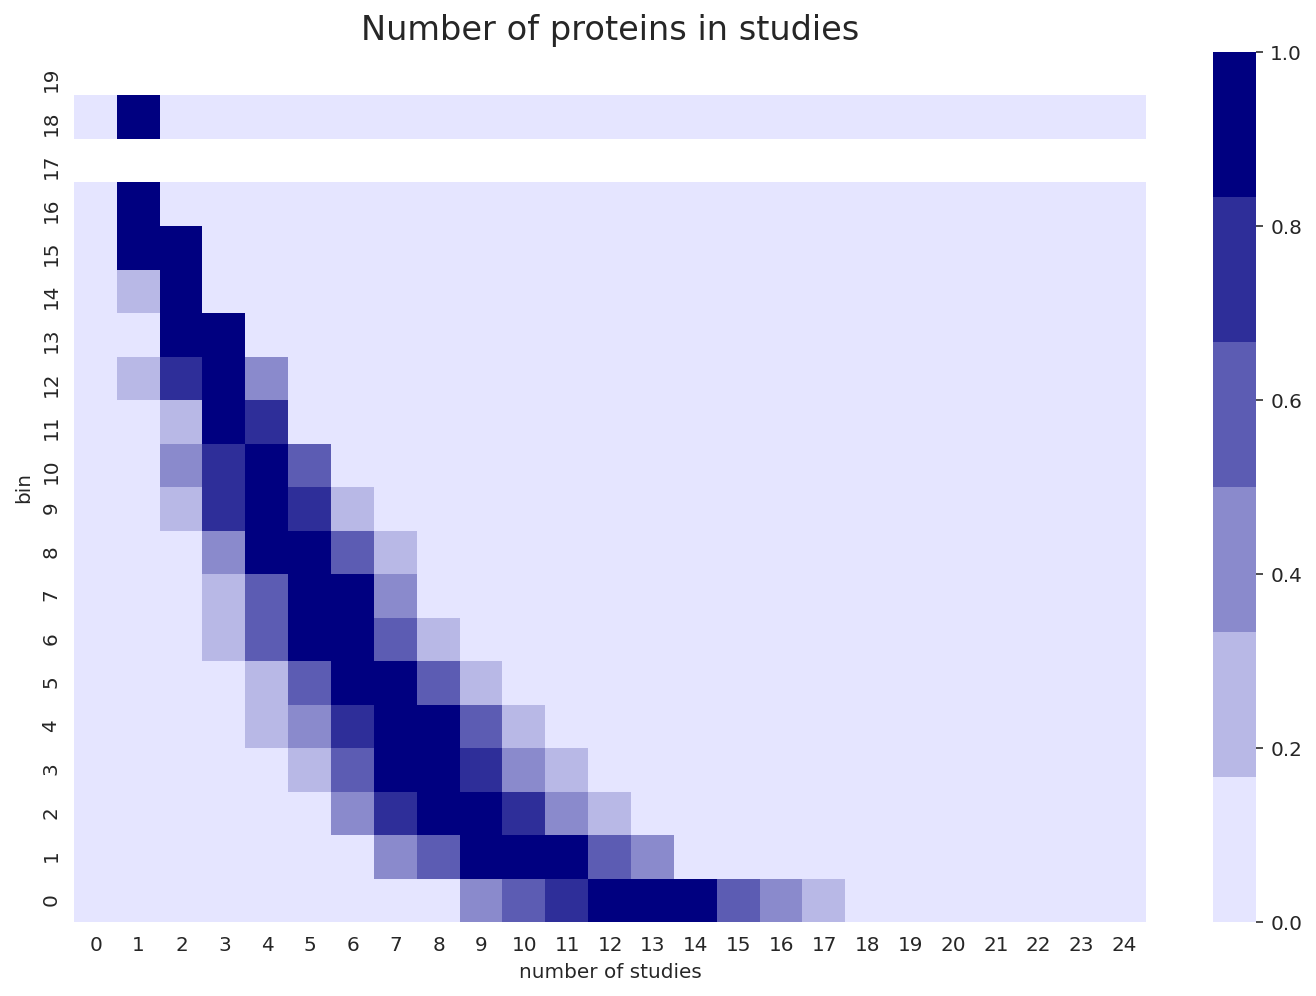

In [42]:
fig = plt.figure(figsize=(12, 8))

ax = sns.heatmap(heatmap_data_f,cmap=sns.light_palette("navy"))
ax.invert_yaxis()

ax.set_xlabel('number of studies')
ax.set_ylabel('bin')

ax.set_xlim(0, 25)

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.title('Number of proteins in studies')


plt.show()


#fig.savefig('../plots/S2B_Studies_NcommonProteinsAndNprot_28july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S2B_Studies_NcommonProteinsAndNprot_28july2020.svg', transparent=True)



In [77]:
df_sort['location'].unique()

array(['nucleus', 'mitochondria', 'subcellular not specified', 'endosome',
       'large protein complex', 'actin binding proteins', 'er',
       'plasma membrane', 'golgi', 'peroxisome', 'lysosome', 'brain',
       'cortex', 'striatum', 'cerebellum', 'spinal cord', 'hippocampus',
       'brainstem', 'olfactory bulb', 'midbrain', 'medulla',
       'medial subependymal zone', 'subependymal zone', 'microglia',
       'amygdala', 'thalamus', 'neurons', 'corpus callosum',
       'oligodendrocytes', 'optic nerve', 'astrocytes', 'axon', 'csf',
       'cytoplasm'], dtype=object)

In [52]:
dfl= df_sort[df_sort['location'].isin(['hippocampus', 'cerebellum', 'cortex', 'striatum', 'brainstem',
'spinal cord', 'medulla', 'midbrain', 'olfactory bulb',
'thalamus', 'amygdala', 'corpus callosum'])][['location','gene_id_final','log_conc_uM_medNorm']].groupby(['location','gene_id_final']).median()
dfl = dfl.reset_index()

d = {name: dfl[dfl['location']==name] for name in dfl['location'].unique()}

gene_stl = dict()

for st in df_sort[df_sort['location'].isin(['hippocampus', 'cerebellum', 'cortex', 'striatum', 'brainstem',
'spinal cord', 'medulla', 'midbrain', 'olfactory bulb',
'thalamus', 'amygdala', 'corpus callosum'])]['location'].unique():
    gene_stl[st] = df_sort[df_sort['location']==st]['gene_id_final'].unique()

c1 = set(list(gene_stl.values())[0])
l1 = list()

for gs in list(gene_stl.values())[1:len(gene_stl.values())]:
    sc1 = set(c1)
    c1 = sc1.intersection(gs)
    
    l1.append(len(c1))
    
    
import itertools 


ll_gene_st_v = [l.tolist() for l in list(gene_stl.values())]


#print(combinationsList(ll_gene_st_v[0:3], 2))

commonGenesAll = list(set.intersection(*map(set, ll_gene_st_v))) 


print(len(ll_gene_st_v))

ll_gene_st_v_sets = [set(l) for l in ll_gene_st_v]


cache = {str(i):s for i,s in enumerate(ll_gene_st_v_sets)}

n = len(ll_gene_st_v_sets)
indexes = [i for i in range(n)]

for i in range(2, n):
    indexes_comb = itertools.combinations(indexes, i)
    print(i)
    for comb in indexes_comb:
        comb_l = list(comb)
        comb_str = [str(c) for c in comb_l]
        key = " ".join(comb_str)
        prev_key = " ".join(comb_str[0:-1])
        last_set = ll_gene_st_v_sets[comb_l[-1]]
        cache[key] = last_set.intersection(cache[prev_key])

len(df_sort.loc[df_sort['location'].isin(['hippocampus', 'cerebellum', 'cortex', 'striatum', 'brainstem',
'spinal cord', 'medulla', 'midbrain', 'olfactory bulb',
'thalamus', 'amygdala', 'corpus callosum']),'location'].unique())

commonGenesLocNumList = {i: [] for i in range(1, 12)}

for k, v in cache.items():
    commonGenesLocNumList[len(k.split(" "))].append(len(v))

print(np.max(commonGenesLocNumList[1]))

keys = [k for k in commonGenesLocNumList.keys() for v in commonGenesLocNumList[k]]
values = [v for k in commonGenesLocNumList.keys() for v in commonGenesLocNumList[k]]

commonGenesLocDfg = pd.DataFrame.from_dict({'numLocations': keys, 'numCommonGenes': values})
commonGenesLocDfg.head()


12
2
3
4
5
6
7
8
9
10
11
12165


numLocations  numCommonGenes
0             1           12165
1             1           10317
2             1           11067
3             1            7121
4             1            9698

In [53]:
commonGenesLocDfg.loc[commonGenesLocDfg['numCommonGenes']==np.max(commonGenesLocDfg['numCommonGenes'])].head(15)

numLocations  numCommonGenes
0             1           12165

In [54]:
commonGenesLocDfg.loc[(commonGenesLocDfg['numCommonGenes']>10000) & (commonGenesLocDfg['numCommonGenes']<11500)].head(15)

numLocations  numCommonGenes
1              1           10317
2              1           11067
12             2           10177
13             2           10690

In [55]:
max_val = np.max(commonGenesLocNumList[1]) 
num_bins = 20

max_val

12165

In [56]:
bins = [ i*13000 // num_bins for i in range(num_bins+1)] #12186 # 12165

In [60]:
print(bins)

[0, 650, 1300, 1950, 2600, 3250, 3900, 4550, 5200, 5850, 6500, 7150, 7800, 8450, 9100, 9750, 10400, 11050, 11700, 12350, 13000]


In [57]:
bins[18]

11700

In [58]:
heatmap_data = np.zeros((n, num_bins))
for i in range(12):
    heatmap_data[i] = np.histogram(commonGenesLocDfg.loc[commonGenesLocDfg["numLocations"] == i,"numCommonGenes"], bins=bins)[0]

heatmap_data_f = heatmap_data / heatmap_data.max(axis=0)

heatmap_data_f = heatmap_data_f.transpose()

np.min(commonGenesLocNumList[1]) 

/gpfs/bbp.cscs.ch/home/shichkov/molAtlas/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4602

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Text(0.5, 1.0, 'Number of proteins in locations')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


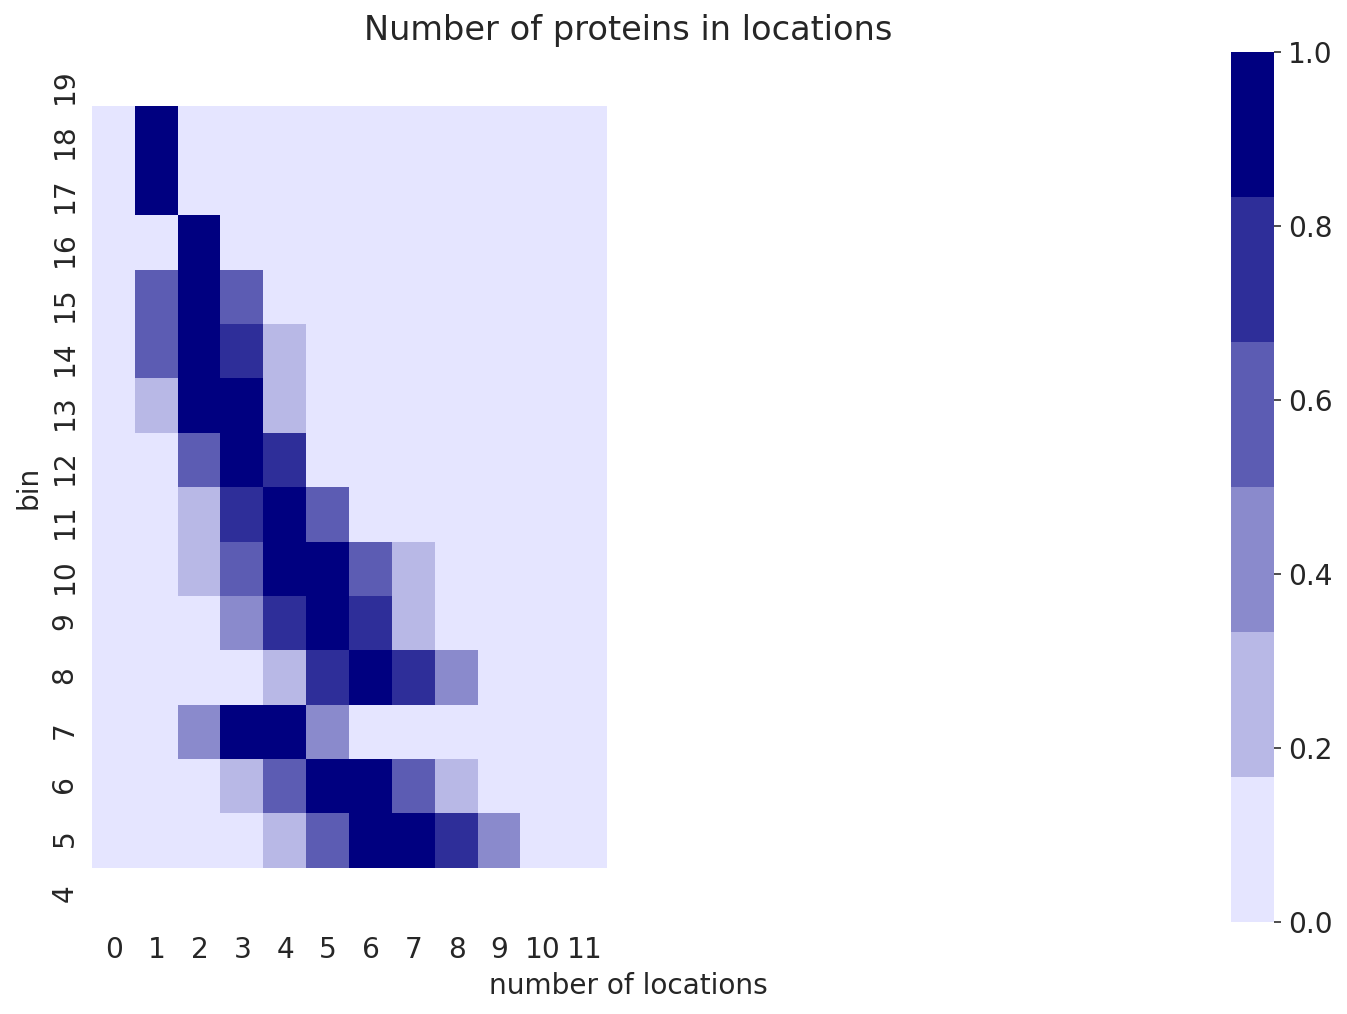

In [59]:
fig = plt.figure(figsize=(12, 8))

ax = sns.heatmap(heatmap_data_f,cmap=sns.light_palette("navy"))
ax.invert_yaxis()

ax.set_xlabel('number of locations')
ax.set_ylabel('bin')

ax.set_xlim(0, 25)
ax.set_ylim(4, 20)

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.title('Number of proteins in locations')


#fig.savefig('../plots/S2D_Locations_NcommonProteinsAndNprot_28july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S2D_Locations_NcommonProteinsAndNprot_28july2020.svg', transparent=True)



In [61]:
df_sort['location'].unique()

array(['nucleus', 'mitochondria', 'subcellular not specified', 'endosome',
       'large protein complex', 'actin binding proteins', 'er',
       'plasma membrane', 'golgi', 'peroxisome', 'lysosome', 'brain',
       'cortex', 'striatum', 'cerebellum', 'spinal cord', 'hippocampus',
       'brainstem', 'olfactory bulb', 'midbrain', 'medulla',
       'medial subependymal zone', 'subependymal zone', 'microglia',
       'amygdala', 'thalamus', 'neurons', 'corpus callosum',
       'oligodendrocytes', 'optic nerve', 'astrocytes', 'axon', 'csf',
       'cytoplasm'], dtype=object)

In [62]:
dfl= df_sort[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes'])][['location','gene_id_final','log_conc_uM_medNorm']].groupby(['location','gene_id_final']).median()
dfl = dfl.reset_index()

d = {name: dfl[dfl['location']==name] for name in dfl['location'].unique()}

gene_stl = dict()

for st in df_sort[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes'])]['location'].unique():
    gene_stl[st] = df_sort[df_sort['location']==st]['gene_id_final'].unique()

c1 = set(list(gene_stl.values())[0])
l1 = list()

for gs in list(gene_stl.values())[1:len(gene_stl.values())]:
    sc1 = set(c1)
    c1 = sc1.intersection(gs)
    
    l1.append(len(c1))
    
    
import itertools 


ll_gene_st_v = [l.tolist() for l in list(gene_stl.values())]


#print(combinationsList(ll_gene_st_v[0:3], 2))

commonGenesAll = list(set.intersection(*map(set, ll_gene_st_v))) 


print(len(ll_gene_st_v))

ll_gene_st_v_sets = [set(l) for l in ll_gene_st_v]


cache = {str(i):s for i,s in enumerate(ll_gene_st_v_sets)}

n = len(ll_gene_st_v_sets)
indexes = [i for i in range(n)]

for i in range(2, n):
    indexes_comb = itertools.combinations(indexes, i)
    print(i)
    for comb in indexes_comb:
        comb_l = list(comb)
        comb_str = [str(c) for c in comb_l]
        key = " ".join(comb_str)
        prev_key = " ".join(comb_str[0:-1])
        last_set = ll_gene_st_v_sets[comb_l[-1]]
        cache[key] = last_set.intersection(cache[prev_key])

print(len(df_sort.loc[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes']),'location'].unique()))

commonGenesLocNumList = {i: [] for i in range(1, 5)}

for k, v in cache.items():
    commonGenesLocNumList[len(k.split(" "))].append(len(v))

print(np.max(commonGenesLocNumList[1]))

keys = [k for k in commonGenesLocNumList.keys() for v in commonGenesLocNumList[k]]
values = [v for k in commonGenesLocNumList.keys() for v in commonGenesLocNumList[k]]

commonGenesLocDfg = pd.DataFrame.from_dict({'numLocations': keys, 'numCommonGenes': values})
commonGenesLocDfg.head()


4
2
3
4
9815


numLocations  numCommonGenes
0             1            9448
1             1            9815
2             1            9548
3             1            9701
4             2            8582

In [63]:

print(len(df_sort.loc[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes']),'location'].unique()))

4


In [64]:
commonGenesLocDfg.loc[commonGenesLocDfg['numCommonGenes']==np.max(commonGenesLocDfg['numCommonGenes'])].head(15)

numLocations  numCommonGenes
1             1            9815

In [65]:
max_val = np.max(commonGenesLocNumList[1]) 
num_bins = 20

max_val

9815

In [66]:
bins = [ i*10000 // num_bins for i in range(num_bins+1)]

In [68]:
print(bins)

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


In [69]:
heatmap_data = np.zeros((n, num_bins))
for i in range(4):
    heatmap_data[i] = np.histogram(commonGenesLocDfg.loc[commonGenesLocDfg["numLocations"] == i,"numCommonGenes"], bins=bins)[0]

heatmap_data_f = heatmap_data / heatmap_data.max(axis=0)

heatmap_data_f = heatmap_data_f.transpose()

np.min(commonGenesLocNumList[1]) 

/gpfs/bbp.cscs.ch/home/shichkov/molAtlas/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


9448

Text(0.5, 1.0, 'Number of proteins in locations')

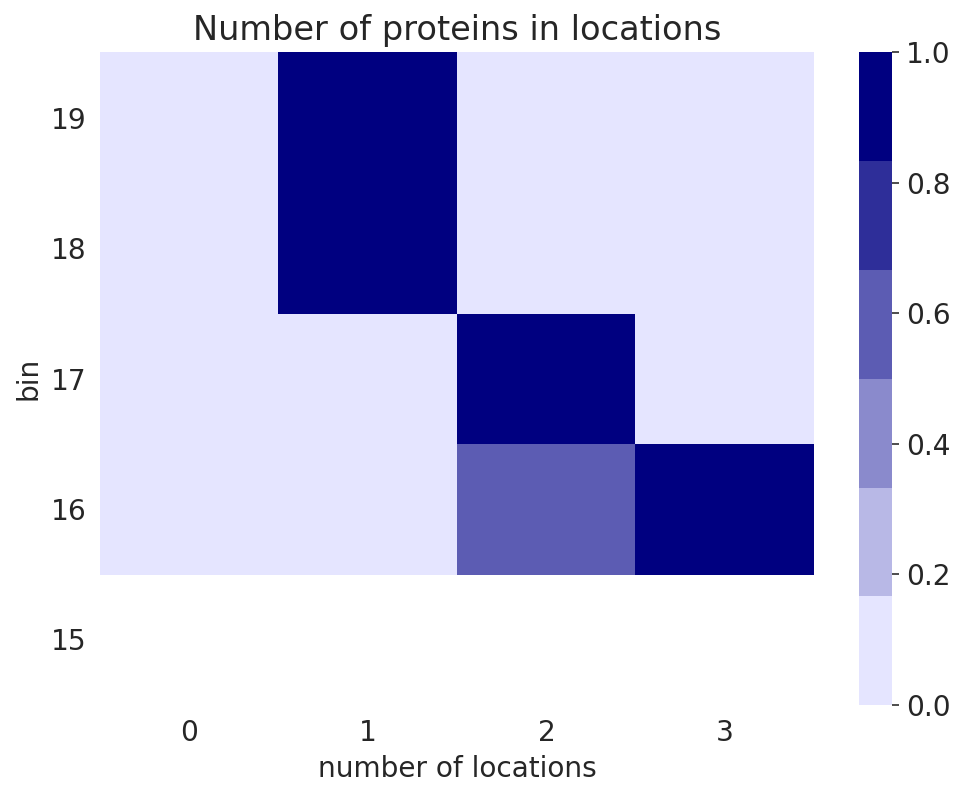

In [70]:
fig = plt.figure(figsize=(8, 6))

ax = sns.heatmap(heatmap_data_f,cmap=sns.light_palette("navy"))
ax.invert_yaxis()

ax.set_xlabel('number of locations')
ax.set_ylabel('bin')

ax.set_xlim(0, 4)
ax.set_ylim(15, 20)

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.title('Number of proteins in locations')

#fig.savefig('../plots/S2F_LocationsCellTypes_NcommonProteinsAndNprot_28july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/S2F_LocationsCellTypes_NcommonProteinsAndNprot_28july2020.svg', transparent=True)



In [96]:
df_sort.columns

Index(['Study', 'Organism', 'location', 'Age_cat', 'condition',
       'gene_id_final', 'log_raw_data', 'log_conc_uM_medNorm'],
      dtype='object')

In [97]:
dfgs = df_sort[['Study','gene_id_final','log_conc_uM_medNorm']].groupby(['Study','gene_id_final']).median()
dfgs = dfgs.reset_index()
dfgs.head()

Study gene_id_final  log_conc_uM_medNorm
0  Bai 2020          A1BG            -4.764461
1  Bai 2020          AAAS            -3.446505
2  Bai 2020          AACS            -1.774854
3  Bai 2020         AAGAB            -2.305413
4  Bai 2020          AAK1             1.244455

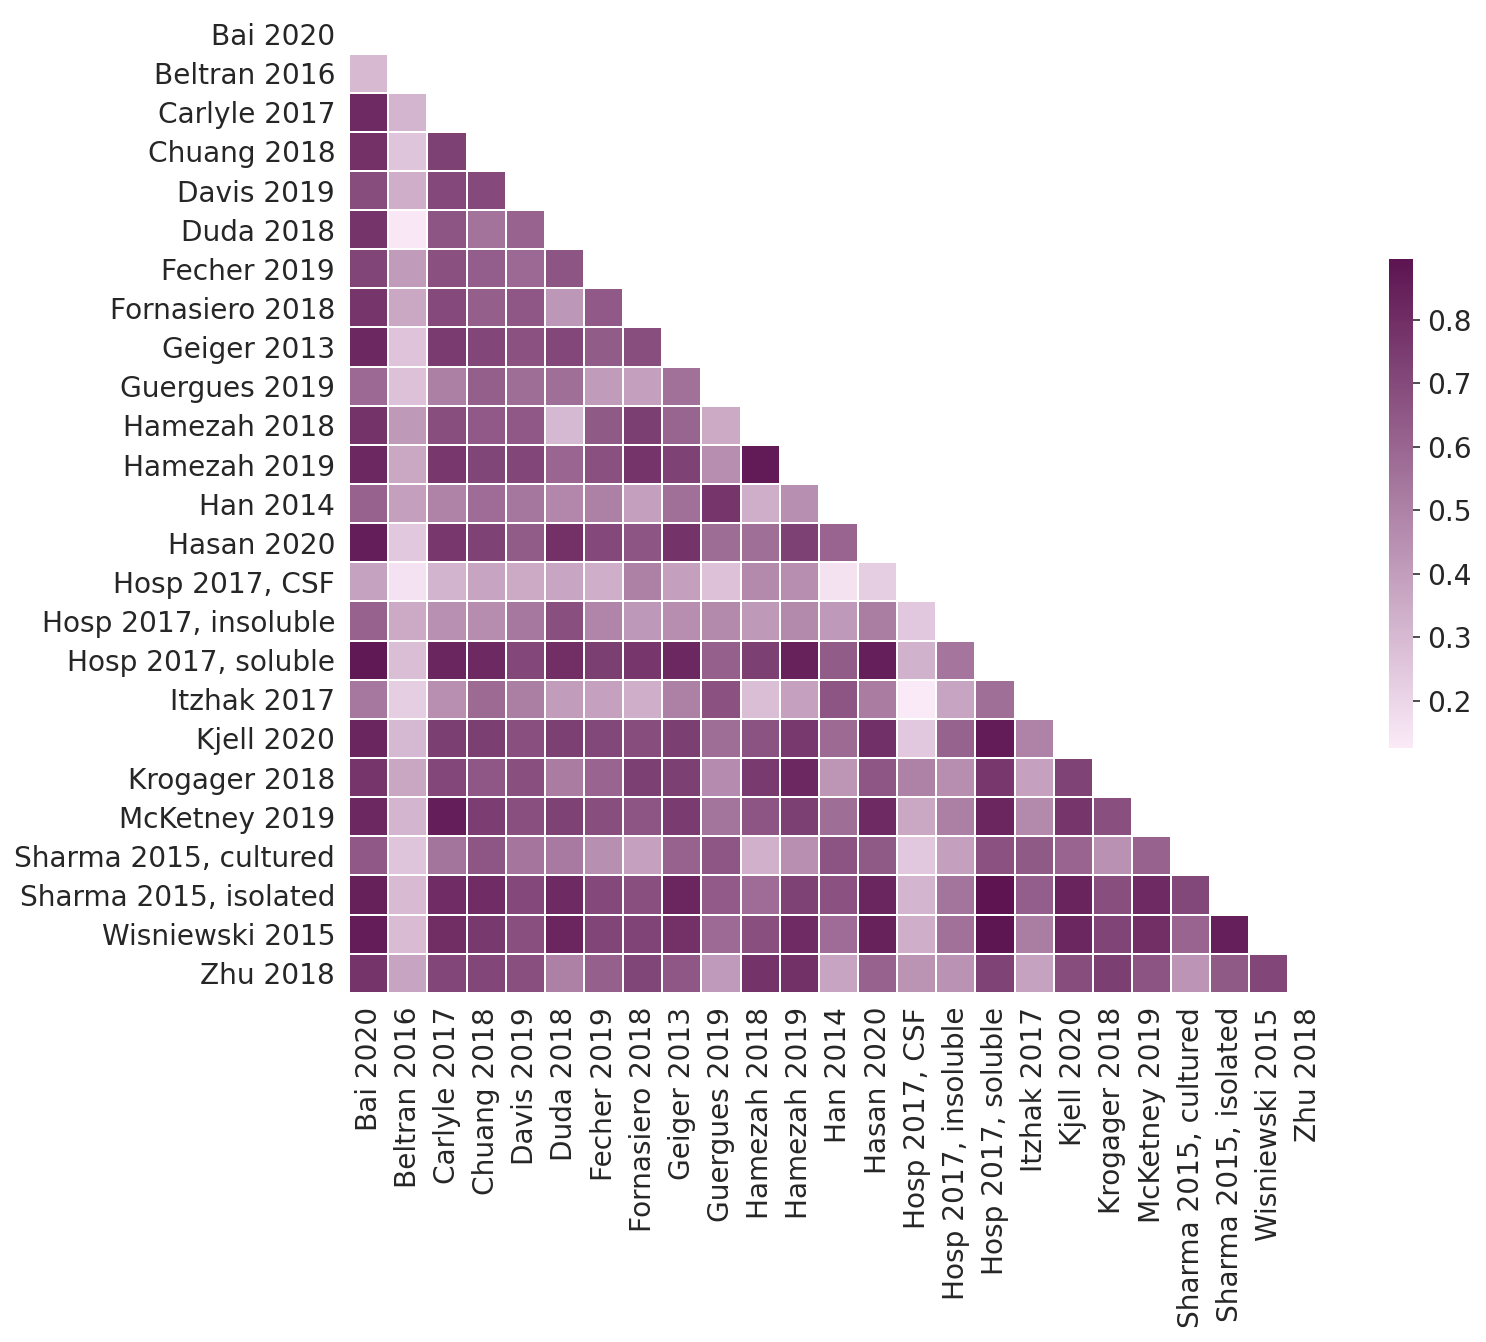

In [100]:
d = {name: dfgs[dfgs['Study']==name] for name in dfgs['Study'].unique()}


gene_st = dict()

for st in df_sort['Study'].unique():
    gene_st[st] = df_sort[df_sort['Study']==st]['gene_id_final'].unique()

###


n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()


dfgs= df_sort[['Study','gene_id_final','log_conc_uM_medNorm']].groupby(['Study','gene_id_final']).median()


dfgs = dfgs.reset_index()

d = {name: dfgs[dfgs['Study']==name] for name in dfgs['Study'].unique()}




from scipy.stats.stats import pearsonr   

for key, value in d.items():
    #print(key)
    for key2, value2 in d.items():
        #if key2!=key:

        value = value.reset_index(drop=True)
        value2 = value2.reset_index(drop=True)
        
        c1 = set(list(gene_st[value['Study'][0]]))
        c2 = set(list(gene_st[value2['Study'][0]]))

        cg = c1.intersection(c2)

        n_comm_genes[key + " and " + key2] = len(cg)

        study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
        study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']


        vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

        PearsonR[key + " and " + key2] = vPearsonR
        PearsonRpval[key + " and " + key2] = vPearsonRpval

        cdf.loc[key,key2] = vPearsonR
        cndf.loc[key,key2] = len(cg)
            
mask = np.zeros_like(cdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)

ax = sns.heatmap(cdf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#f.savefig('../plots/fig3A_studies_corr_28july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/fig3A_studies_corr_28july2020.svg', transparent=True)


In [101]:
PearsonR

{'Bai 2020 and Bai 2020': 1.0,
 'Bai 2020 and Beltran 2016': 0.3008014319263711,
 'Bai 2020 and Carlyle 2017': 0.8091738583860087,
 'Bai 2020 and Chuang 2018': 0.7885776465250816,
 'Bai 2020 and Davis 2019': 0.688809984119473,
 'Bai 2020 and Duda 2018': 0.7786222154830726,
 'Bai 2020 and Fecher 2019': 0.7199949176070501,
 'Bai 2020 and Fornasiero 2018': 0.774263577785901,
 'Bai 2020 and Geiger 2013': 0.8189298142607105,
 'Bai 2020 and Guergues 2019': 0.5903578736049933,
 'Bai 2020 and Hamezah 2018': 0.7806657892994868,
 'Bai 2020 and Hamezah 2019': 0.8234709862779295,
 'Bai 2020 and Han 2014': 0.6114025078452884,
 'Bai 2020 and Hasan 2020': 0.8586514149166972,
 'Bai 2020 and Hosp 2017, CSF': 0.3863488072097767,
 'Bai 2020 and Hosp 2017, insoluble': 0.6112289378074001,
 'Bai 2020 and Hosp 2017, soluble': 0.8774628350696237,
 'Bai 2020 and Itzhak 2017': 0.5369110586334647,
 'Bai 2020 and Kjell 2020': 0.8308188627302479,
 'Bai 2020 and Krogager 2018': 0.7712603011900404,
 'Bai 2020 and Mc

In [102]:
PearsonRpval

{'Bai 2020 and Bai 2020': 0.0,
 'Bai 2020 and Beltran 2016': 3.6355009943005614e-46,
 'Bai 2020 and Carlyle 2017': 0.0,
 'Bai 2020 and Chuang 2018': 0.0,
 'Bai 2020 and Davis 2019': 0.0,
 'Bai 2020 and Duda 2018': 2.8966678181268785e-89,
 'Bai 2020 and Fecher 2019': 0.0,
 'Bai 2020 and Fornasiero 2018': 1.2846e-320,
 'Bai 2020 and Geiger 2013': 0.0,
 'Bai 2020 and Guergues 2019': 0.0,
 'Bai 2020 and Hamezah 2018': 2.461980925630266e-223,
 'Bai 2020 and Hamezah 2019': 0.0,
 'Bai 2020 and Han 2014': 0.0,
 'Bai 2020 and Hasan 2020': 0.0,
 'Bai 2020 and Hosp 2017, CSF': 1.696014485195175e-24,
 'Bai 2020 and Hosp 2017, insoluble': 8.343251897719764e-128,
 'Bai 2020 and Hosp 2017, soluble': 0.0,
 'Bai 2020 and Itzhak 2017': 0.0,
 'Bai 2020 and Kjell 2020': 0.0,
 'Bai 2020 and Krogager 2018': 0.0,
 'Bai 2020 and McKetney 2019': 0.0,
 'Bai 2020 and Sharma 2015, cultured': 0.0,
 'Bai 2020 and Sharma 2015, isolated': 0.0,
 'Bai 2020 and Wisniewski 2015': 0.0,
 'Bai 2020 and Zhu 2018': 3.74620781

In [103]:
ndf = pd.merge(d['Bai 2020'],
                   d['Kjell 2020'], how='inner',
                  on='gene_id_final' )
ndf.columns

Index(['Study_x', 'gene_id_final', 'log_conc_uM_medNorm_x', 'Study_y',
       'log_conc_uM_medNorm_y'],
      dtype='object')

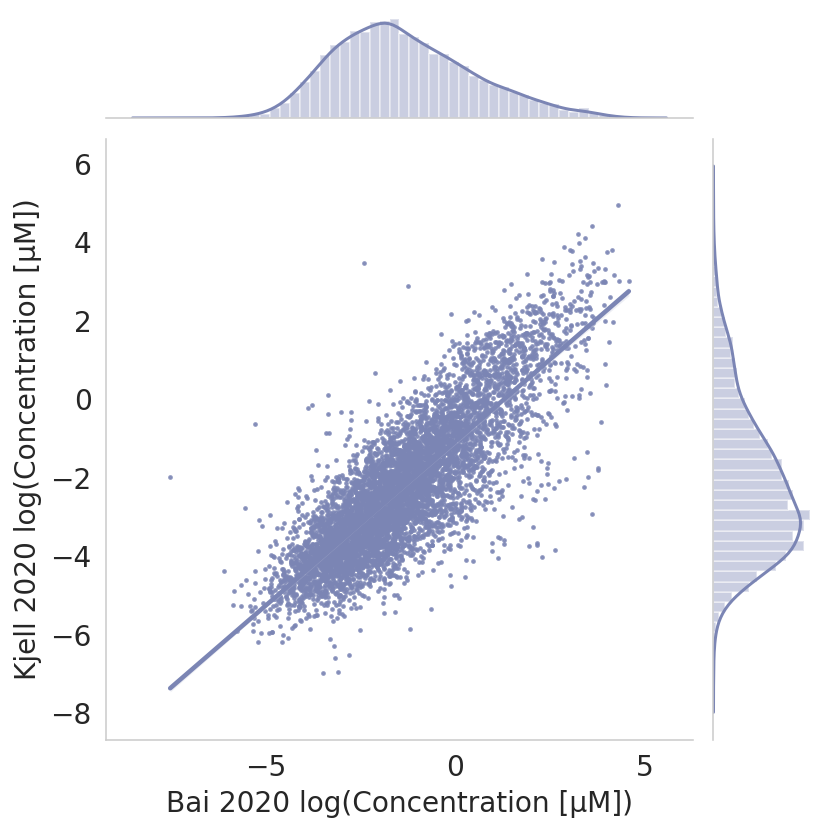

In [104]:
fig = plt.figure(figsize=(8, 6))

g = sns.jointplot("log_conc_uM_medNorm_x", "log_conc_uM_medNorm_y",
                  data=ndf, kind="reg",marker='o', scatter_kws={'s':2},color="#7b85b4") #  xlim=(0, 60), ylim=(0, 12),

g.ax_joint.set_xlabel('Bai 2020 log(Concentration [µM])')
g.ax_joint.set_ylabel('Kjell 2020 log(Concentration [µM])')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

fig.tight_layout()

#g.savefig('../plots/fig3B_joint_STUDY_example_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)


plt.close(fig)

Bai 2020
Beltran 2016
Carlyle 2017
Chuang 2018
Davis 2019
Duda 2018
Fecher 2019
Fornasiero 2018
Geiger 2013
Guergues 2019
Hamezah 2018
Hamezah 2019
Han 2014
Hasan 2020
Hosp 2017, CSF
Hosp 2017, insoluble
Hosp 2017, soluble
Itzhak 2017
Kjell 2020
Krogager 2018
McKetney 2019
Sharma 2015, cultured
Sharma 2015, isolated
Wisniewski 2015
Zhu 2018


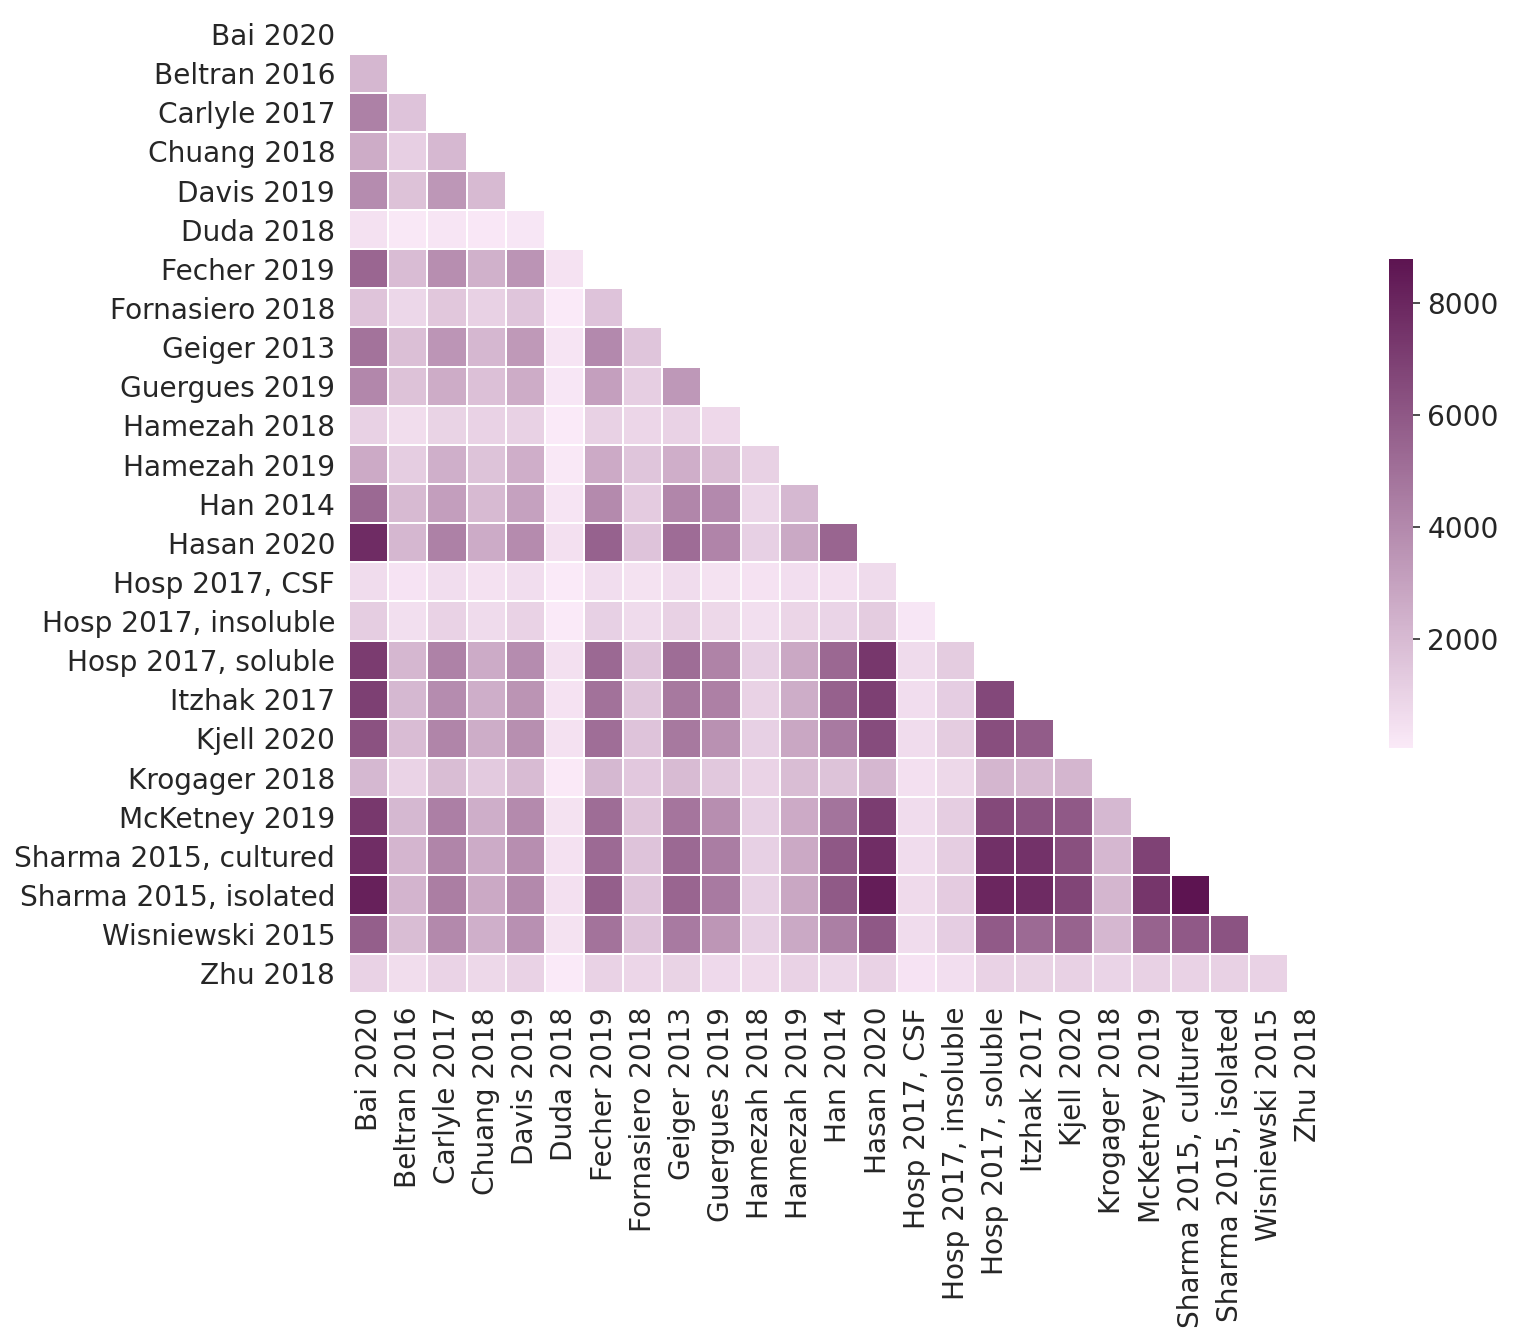

In [105]:
n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()


dfgs= df_sort[['Study','gene_id_final','log_conc_uM_medNorm']].groupby(['Study','gene_id_final']).median()


dfgs = dfgs.reset_index()

d = {name: dfgs[dfgs['Study']==name] for name in dfgs['Study'].unique()}





from scipy.stats.stats import pearsonr   

for key, value in d.items():
    print(key)
    for key2, value2 in d.items():
        if key2!=key:
            
            value = value.reset_index(drop=True)
            value2 = value2.reset_index(drop=True)
            
            c1 = set(list(gene_st[value['Study'][0]]))
            c2 = set(list(gene_st[value2['Study'][0]]))
            
            cg = c1.intersection(c2)

            n_comm_genes[key + " and " + key2] = len(cg)
            
            study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            
            
            vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

            PearsonR[key + " and " + key2] = vPearsonR
            PearsonRpval[key + " and " + key2] = vPearsonRpval
            
            cdf.loc[key,key2] = vPearsonR
            cndf.loc[key,key2] = len(cg)
        


cndf = cndf[cndf.index]

mask = np.zeros_like(cndf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)

ax = sns.heatmap(cndf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#f.savefig('../plots/S2A_studies_Ncomm_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/S2A_studies_Ncomm_13july2020.svg', transparent=True)


In [106]:
dfl= df_sort[df_sort['location'].isin(['hippocampus', 'cerebellum', 'cortex', 'striatum', 'brainstem',
'spinal cord', 'medulla', 'midbrain', 'olfactory bulb',
'thalamus', 'amygdala', 'corpus callosum'])][['location','gene_id_final','log_conc_uM_medNorm']].groupby(['location','gene_id_final']).median()
dfl = dfl.reset_index()

d = {name: dfl[dfl['location']==name] for name in dfl['location'].unique()}

gene_stl = dict()

for st in df_sort[df_sort['location'].isin(['hippocampus', 'cerebellum', 'cortex', 'striatum', 'brainstem',
'spinal cord', 'medulla', 'midbrain', 'olfactory bulb',
'thalamus', 'amygdala', 'corpus callosum'])]['location'].unique():
    gene_stl[st] = df_sort[df_sort['location']==st]['gene_id_final'].unique()


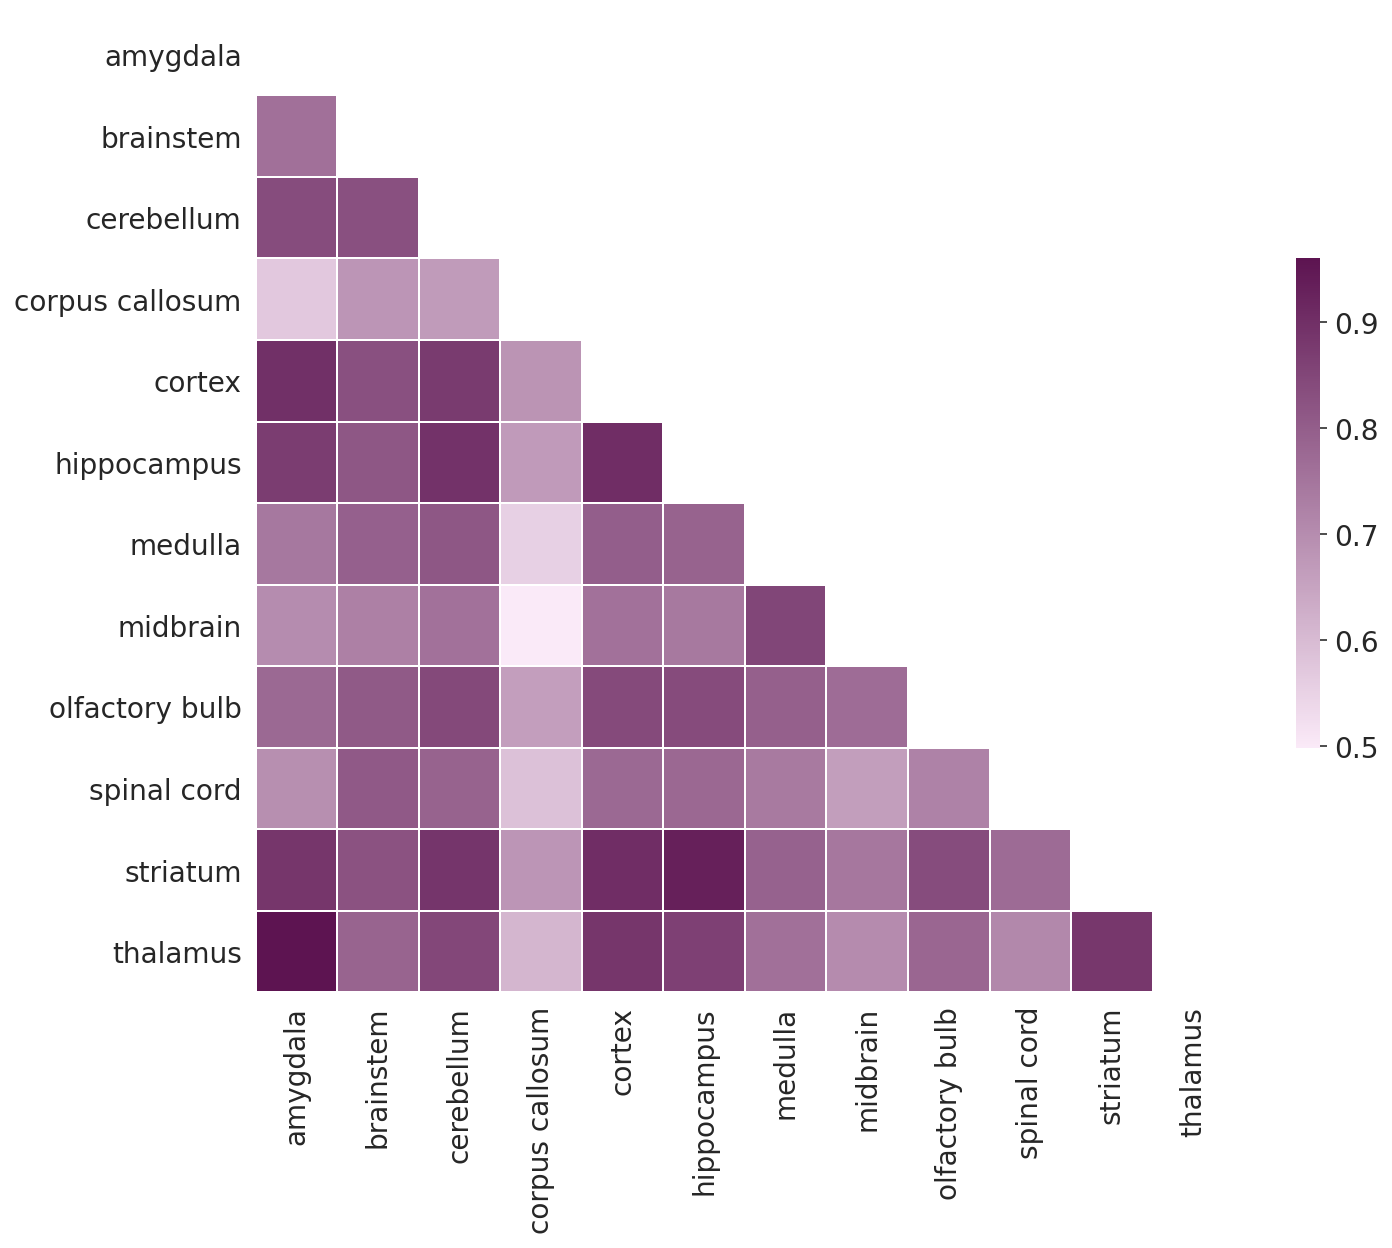

In [107]:
n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()

from scipy.stats.stats import pearsonr   

for key, value in d.items():
    #print(key)
    for key2, value2 in d.items():
        #if key2!=key:

        value = value.reset_index(drop=True)
        value2 = value2.reset_index(drop=True)

        c1 = set(list(gene_stl[value['location'][0]]))
        c2 = set(list(gene_stl[value2['location'][0]]))

        cg = c1.intersection(c2)

        n_comm_genes[key + " and " + key2] = len(cg)

        study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
        study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']


        vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

        PearsonR[key + " and " + key2] = vPearsonR
        PearsonRpval[key + " and " + key2] = vPearsonRpval

        cdf.loc[key,key2] = vPearsonR
        cndf.loc[key,key2] = len(cg)
            



mask = np.zeros_like(cdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)

ax = sns.heatmap(cdf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#f.savefig('../plots/fig3C_brainRegions_corr_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/fig3C_brainRegions_corr_13july2020.svg', transparent=True)


In [108]:
PearsonR

{'amygdala and amygdala': 1.0,
 'amygdala and brainstem': 0.7609963222442795,
 'amygdala and cerebellum': 0.8389717160344038,
 'amygdala and corpus callosum': 0.5723045635364254,
 'amygdala and cortex': 0.8995032784357524,
 'amygdala and hippocampus': 0.8709074452575354,
 'amygdala and medulla': 0.7439560597341386,
 'amygdala and midbrain': 0.7007022920736177,
 'amygdala and olfactory bulb': 0.7773415101406285,
 'amygdala and spinal cord': 0.6958970813253529,
 'amygdala and striatum': 0.886672111749562,
 'amygdala and thalamus': 0.9600460990692979,
 'brainstem and amygdala': 0.7609963222442795,
 'brainstem and brainstem': 1.0,
 'brainstem and cerebellum': 0.8297101698881121,
 'brainstem and corpus callosum': 0.6817139935244754,
 'brainstem and cortex': 0.8285755064763471,
 'brainstem and hippocampus': 0.815112239546433,
 'brainstem and medulla': 0.7948976748414636,
 'brainstem and midbrain': 0.7270621679709519,
 'brainstem and olfactory bulb': 0.810279858946404,
 'brainstem and spinal 

In [109]:
PearsonRpval

{'amygdala and amygdala': 0.0,
 'amygdala and brainstem': 0.0,
 'amygdala and cerebellum': 0.0,
 'amygdala and corpus callosum': 0.0,
 'amygdala and cortex': 0.0,
 'amygdala and hippocampus': 0.0,
 'amygdala and medulla': 0.0,
 'amygdala and midbrain': 0.0,
 'amygdala and olfactory bulb': 0.0,
 'amygdala and spinal cord': 0.0,
 'amygdala and striatum': 0.0,
 'amygdala and thalamus': 0.0,
 'brainstem and amygdala': 0.0,
 'brainstem and brainstem': 0.0,
 'brainstem and cerebellum': 0.0,
 'brainstem and corpus callosum': 0.0,
 'brainstem and cortex': 0.0,
 'brainstem and hippocampus': 0.0,
 'brainstem and medulla': 0.0,
 'brainstem and midbrain': 0.0,
 'brainstem and olfactory bulb': 0.0,
 'brainstem and spinal cord': 0.0,
 'brainstem and striatum': 0.0,
 'brainstem and thalamus': 0.0,
 'cerebellum and amygdala': 0.0,
 'cerebellum and brainstem': 0.0,
 'cerebellum and cerebellum': 0.0,
 'cerebellum and corpus callosum': 0.0,
 'cerebellum and cortex': 0.0,
 'cerebellum and hippocampus': 0.

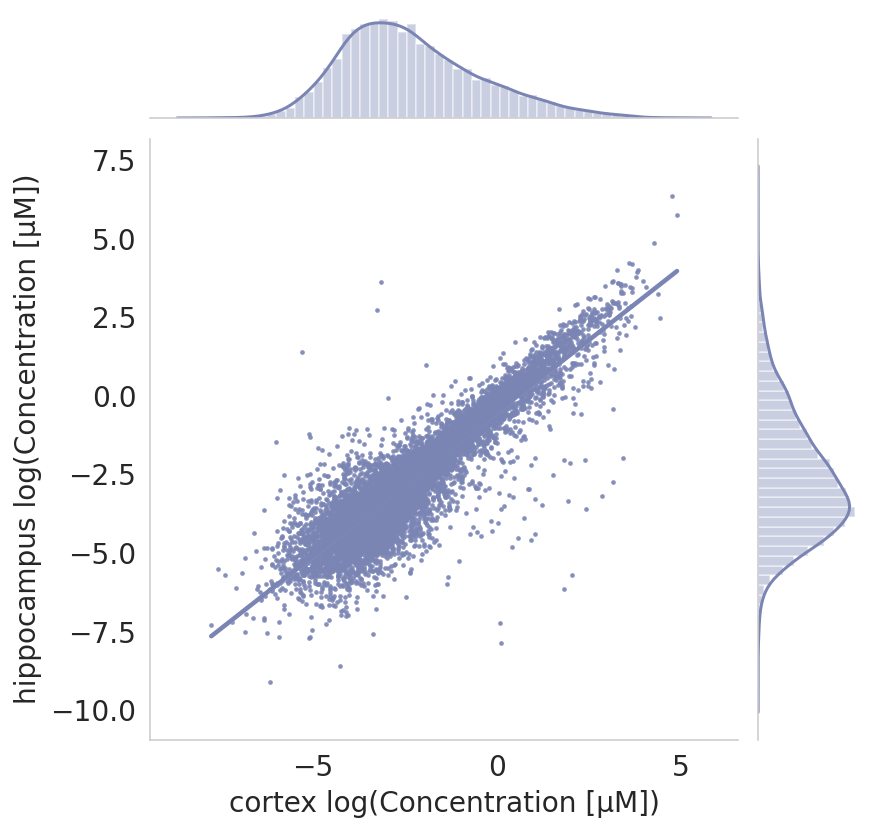

In [110]:
ndf = pd.merge(d['cortex'],
                   d['hippocampus'], how='inner',
                  on='gene_id_final' )

fig = plt.figure(figsize=(8, 6))

g = sns.jointplot("log_conc_uM_medNorm_x", "log_conc_uM_medNorm_y",
                  data=ndf, kind="reg",marker='o', scatter_kws={'s':2},color="#7b85b4") #  xlim=(0, 60), ylim=(0, 12),

g.ax_joint.set_xlabel('cortex log(Concentration [µM])')
g.ax_joint.set_ylabel('hippocampus log(Concentration [µM])')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.grid(False)

#g.savefig('../plots/fig3D_joint_BR_example_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)


plt.close(fig)

amygdala
brainstem
cerebellum
corpus callosum
cortex
hippocampus
medulla
midbrain
olfactory bulb
spinal cord
striatum
thalamus


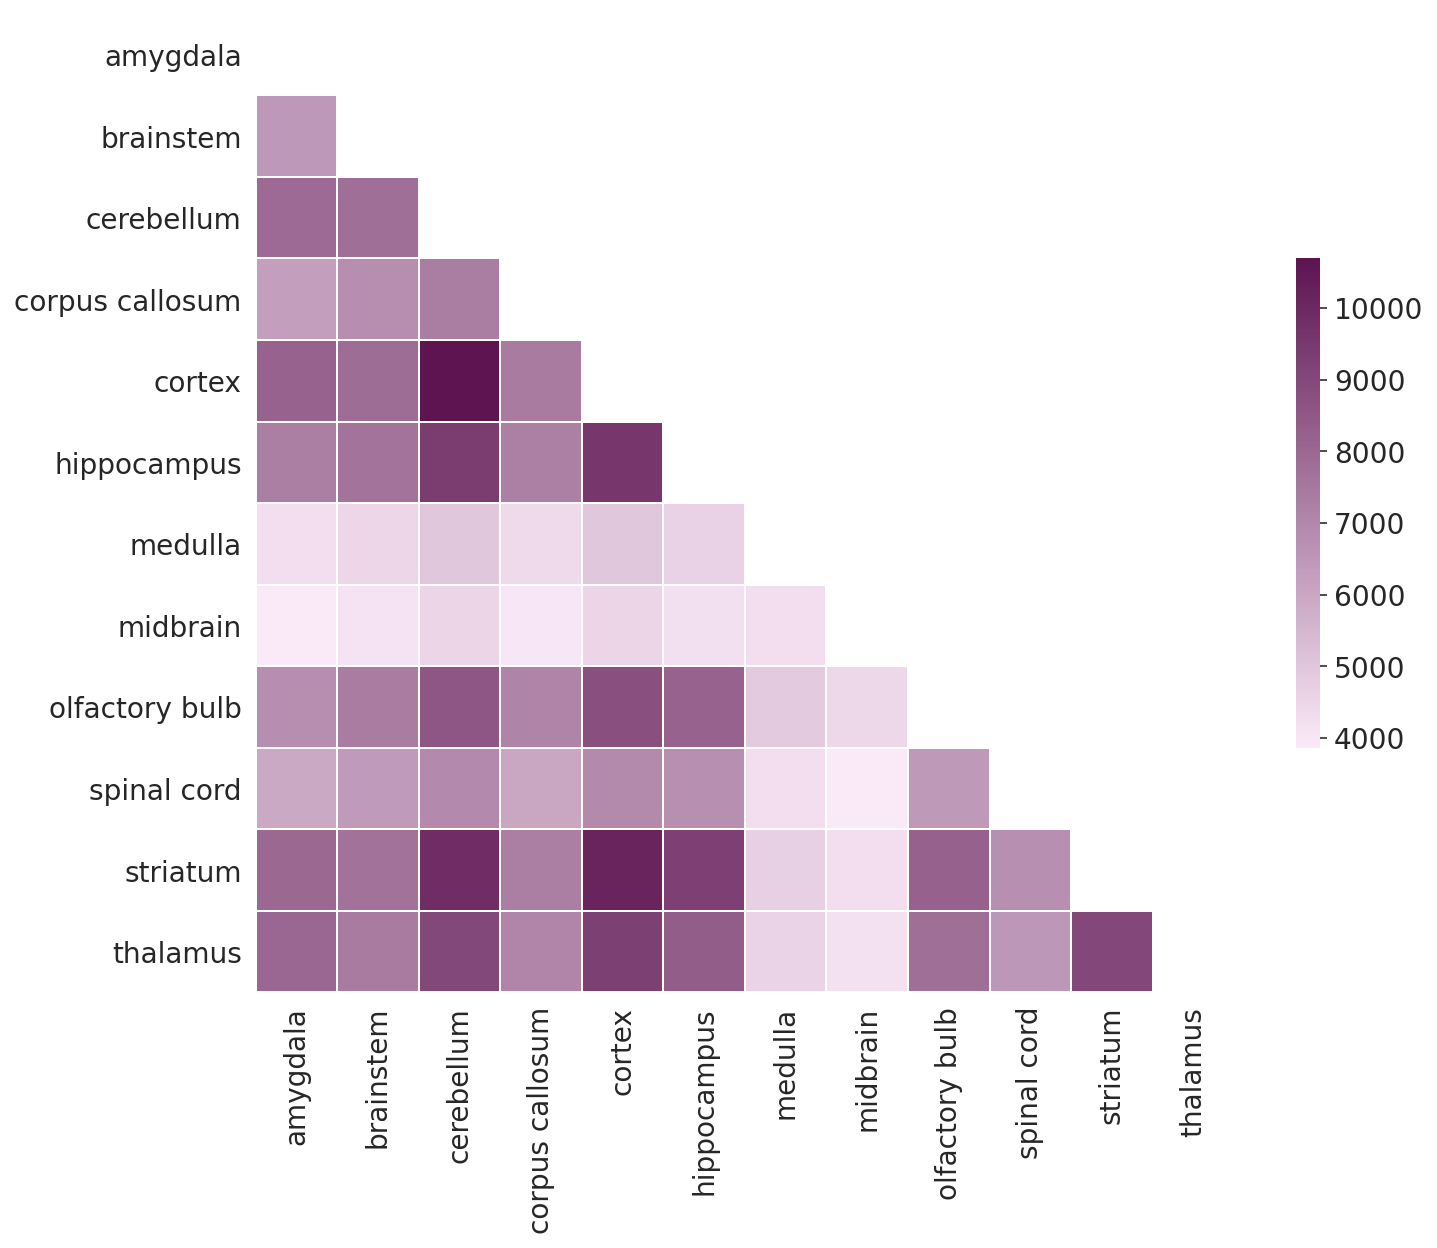

In [111]:
n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()

from scipy.stats.stats import pearsonr   

for key, value in d.items():
    print(key)
    for key2, value2 in d.items():
        if key2!=key:
            
            value = value.reset_index(drop=True)
            value2 = value2.reset_index(drop=True)
            
            c1 = set(list(gene_stl[value['location'][0]]))
            c2 = set(list(gene_stl[value2['location'][0]]))
            
            cg = c1.intersection(c2)

            n_comm_genes[key + " and " + key2] = len(cg)
            
            study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            
            
            vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

            PearsonR[key + " and " + key2] = vPearsonR
            PearsonRpval[key + " and " + key2] = vPearsonRpval
            
            cdf.loc[key,key2] = vPearsonR
            cndf.loc[key,key2] = len(cg)
        


cndf = cndf[cndf.index]

mask = np.zeros_like(cndf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)


ax = sns.heatmap(cndf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#f.savefig('../plots/S2C_brainRegions_Ncomm_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/S2C_brainRegions_Ncomm_13july2020.svg', transparent=True)



In [112]:
#restart kernel
dfl= df_sort[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes'])][['location','gene_id_final','log_conc_uM_medNorm']].groupby(['location','gene_id_final']).median()
dfl = dfl.reset_index()

d = {name: dfl[dfl['location']==name] for name in dfl['location'].unique()}

gene_stl = dict()

for st in df_sort[df_sort['location'].isin(['neurons', 'astrocytes','microglia','oligodendrocytes'])]['location'].unique():
    gene_stl[st] = df_sort[df_sort['location']==st]['gene_id_final'].unique()



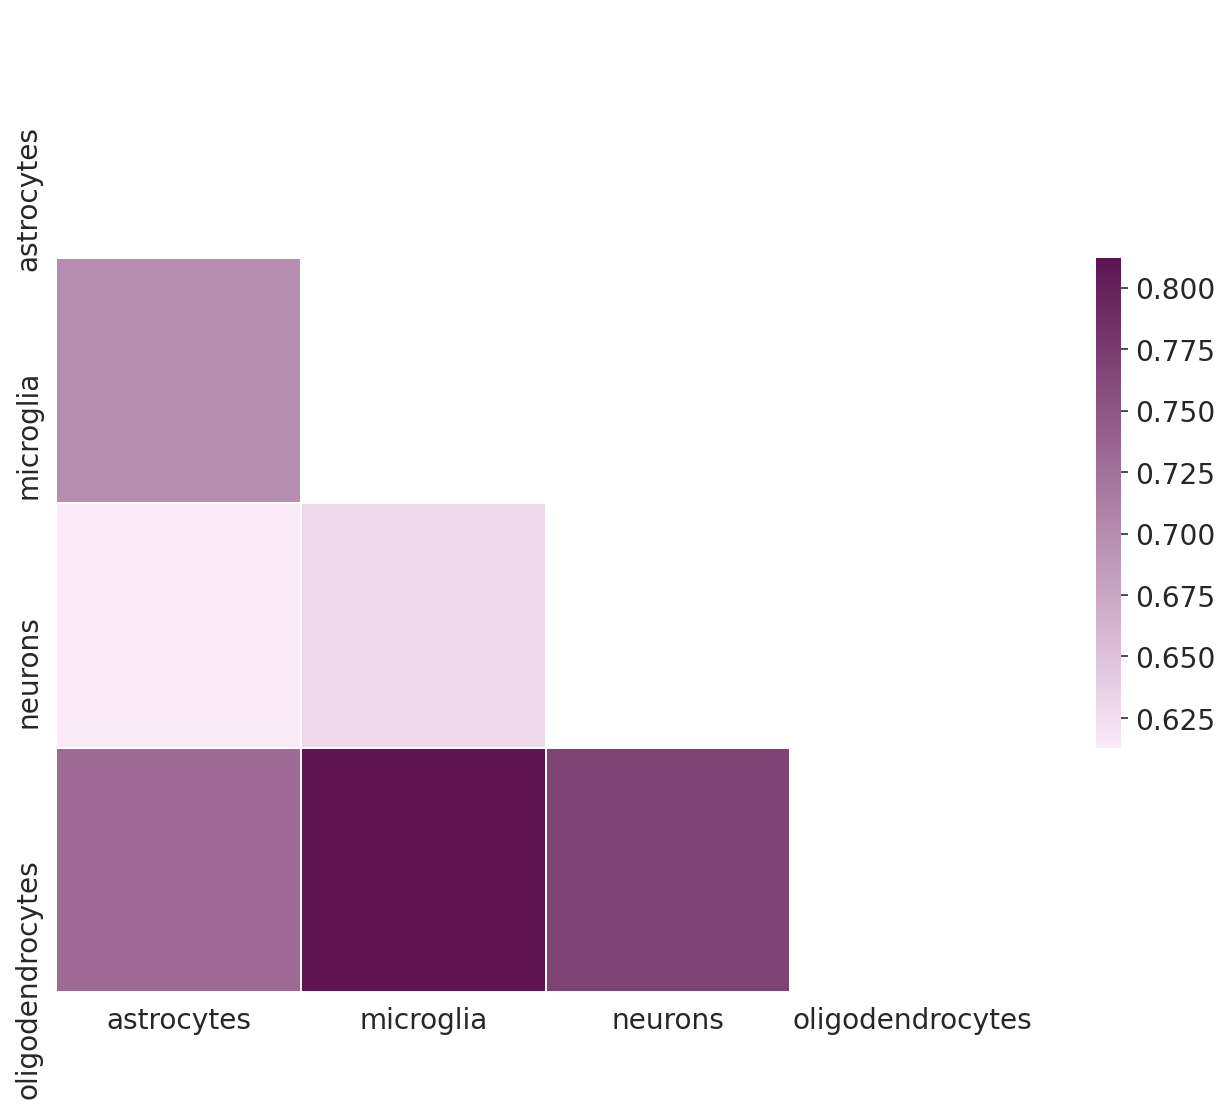

In [113]:
n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()

from scipy.stats.stats import pearsonr   

for key, value in d.items():
    #print(key)
    for key2, value2 in d.items():
        #if key2!=key:

        value = value.reset_index(drop=True)
        value2 = value2.reset_index(drop=True)

        c1 = set(list(gene_stl[value['location'][0]]))
        c2 = set(list(gene_stl[value2['location'][0]]))

        cg = c1.intersection(c2)

        n_comm_genes[key + " and " + key2] = len(cg)

        study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
        study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']


        vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

        PearsonR[key + " and " + key2] = vPearsonR
        PearsonRpval[key + " and " + key2] = vPearsonRpval

        cdf.loc[key,key2] = vPearsonR
        cndf.loc[key,key2] = len(cg)
            


mask = np.zeros_like(cdf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)

ax = sns.heatmap(cdf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#f.savefig('../plots/fig3E_cellTypes_corr_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/fig3E_cellTypes_corr_13july2020.svg', transparent=True)


In [114]:
PearsonR

{'astrocytes and astrocytes': 0.9999999999999999,
 'astrocytes and microglia': 0.6988944235161717,
 'astrocytes and neurons': 0.612968189620618,
 'astrocytes and oligodendrocytes': 0.7309667763953189,
 'microglia and astrocytes': 0.6988944235161717,
 'microglia and microglia': 1.0,
 'microglia and neurons': 0.6289395170196417,
 'microglia and oligodendrocytes': 0.8119612981242237,
 'neurons and astrocytes': 0.612968189620618,
 'neurons and microglia': 0.6289395170196417,
 'neurons and neurons': 1.0,
 'neurons and oligodendrocytes': 0.7686631087594096,
 'oligodendrocytes and astrocytes': 0.7309667763953189,
 'oligodendrocytes and microglia': 0.8119612981242237,
 'oligodendrocytes and neurons': 0.7686631087594096,
 'oligodendrocytes and oligodendrocytes': 1.0}

In [115]:
PearsonRpval

{'astrocytes and astrocytes': 0.0,
 'astrocytes and microglia': 0.0,
 'astrocytes and neurons': 0.0,
 'astrocytes and oligodendrocytes': 0.0,
 'microglia and astrocytes': 0.0,
 'microglia and microglia': 0.0,
 'microglia and neurons': 0.0,
 'microglia and oligodendrocytes': 0.0,
 'neurons and astrocytes': 0.0,
 'neurons and microglia': 0.0,
 'neurons and neurons': 0.0,
 'neurons and oligodendrocytes': 0.0,
 'oligodendrocytes and astrocytes': 0.0,
 'oligodendrocytes and microglia': 0.0,
 'oligodendrocytes and neurons': 0.0,
 'oligodendrocytes and oligodendrocytes': 0.0}

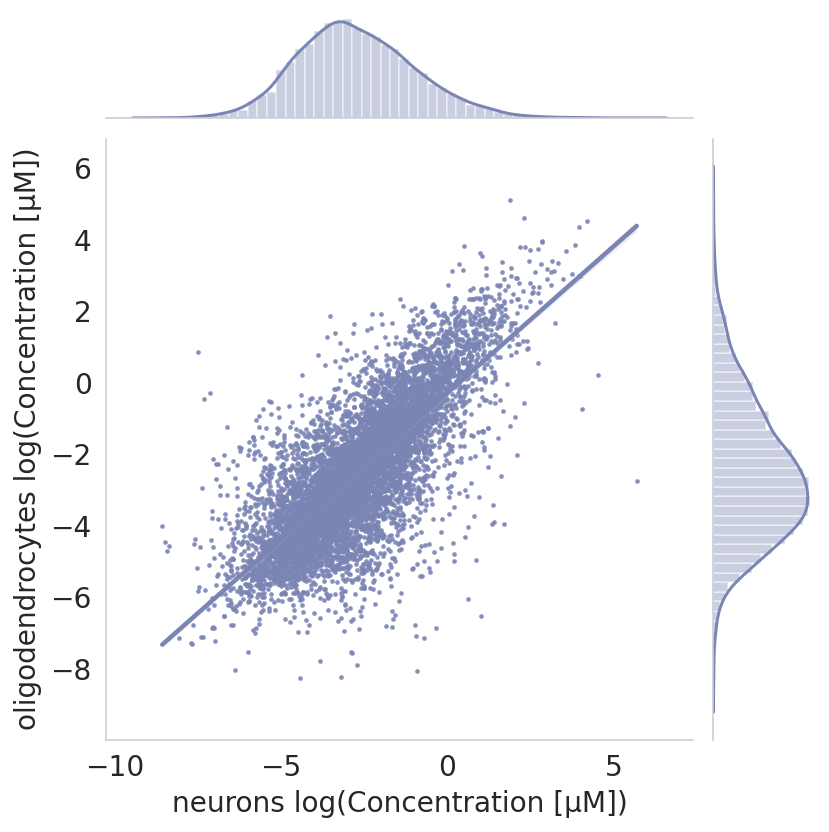

In [116]:
ndf = pd.merge(d['neurons'],
                   d['oligodendrocytes'], how='inner',
                  on='gene_id_final' )

fig = plt.figure(figsize=(8, 6))

g = sns.jointplot("log_conc_uM_medNorm_x", "log_conc_uM_medNorm_y",
                  data=ndf, kind="reg",marker='o', scatter_kws={'s':2},color="#7b85b4") #  xlim=(0, 60), ylim=(0, 12),

g.ax_joint.set_xlabel('neurons log(Concentration [µM])')
g.ax_joint.set_ylabel('oligodendrocytes log(Concentration [µM])')

font = {'family' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

fig.tight_layout()

#g.savefig('../plots/fig3F_joint_CT_example_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)


plt.close(fig)

astrocytes
microglia
neurons
oligodendrocytes


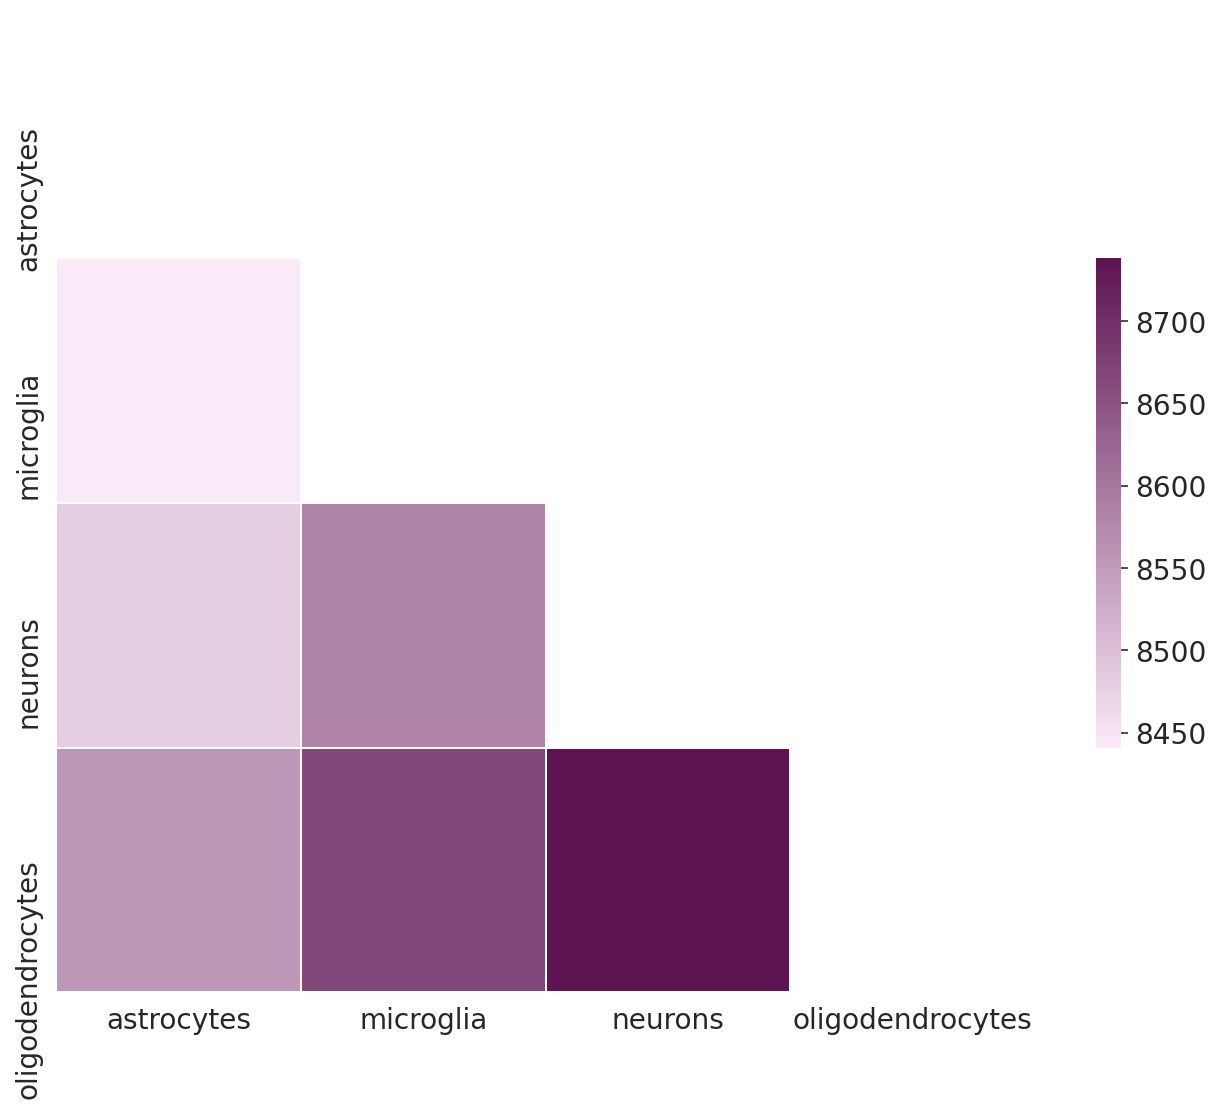

In [117]:
n_comm_genes = dict()
PearsonR = dict()
PearsonRpval = dict()

# corr matrix
cdf = pd.DataFrame()
# num common genes df
cndf = pd.DataFrame()

from scipy.stats.stats import pearsonr   

for key, value in d.items():
    print(key)
    for key2, value2 in d.items():
        if key2!=key:
            
            value = value.reset_index(drop=True)
            value2 = value2.reset_index(drop=True)
            
            c1 = set(list(gene_stl[value['location'][0]]))
            c2 = set(list(gene_stl[value2['location'][0]]))
            
            cg = c1.intersection(c2)

            n_comm_genes[key + " and " + key2] = len(cg)
            
            study1 = value[value['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            study2 = value2[value2['gene_id_final'].isin(cg)]['log_conc_uM_medNorm']
            
            
            vPearsonR,vPearsonRpval  = pearsonr(study1,study2)

            PearsonR[key + " and " + key2] = vPearsonR
            PearsonRpval[key + " and " + key2] = vPearsonRpval
            
            cdf.loc[key,key2] = vPearsonR
            cndf.loc[key,key2] = len(cg)
        


cndf = cndf[cndf.index]

mask = np.zeros_like(cndf, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.light_palette("grape purple", input="xkcd",as_cmap=True)

ax = sns.heatmap(cndf, mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#f.savefig('../plots/S2E_cellTypes_Ncomm_13july2020.png', dpi=300, bbox_inches='tight', transparent=True)
#f.savefig('../plots/S2E_cellTypes_Ncomm_13july2020.svg', transparent=True)


In [118]:
#https://bionumbers.hms.harvard.edu/bionumber.aspx?id=103954&ver=22&trm=104519&org=
# signalling proteins characteristic concentrations

print(np.log(0.01)) # 0.01-1 Table - link µM
print(np.log(1.0))

-4.605170185988091
0.0


In [11]:
signal = pd.read_csv('../data/jaxmgi_signalTransduction_GO_term_summary_2019_may_10_095131.txt',sep='\t')
signal = signal.drop(columns=['Reference(s)'])
signal = signal.reset_index()
signal.columns = ['MGI Gene/Marker ID', 'Symbol', 'Name', 'Chr', 'Qualifier','Annotated Term', 'Context', 
                  'Proteoform', 'Evidence', 'Inferred From','Reference(s)']
signal['Symbol'] = signal['Symbol'].str.upper()
signal['Symbol'] = signal['Symbol'].str.split(' ')
signal = split_df_column_list_to_multiple_rows(signal, target_column='Symbol')
signal = signal.drop(columns=['MGI Gene/Marker ID','Chr', 'Context', 'Evidence', 'Inferred From', 
                              'Name', 'Proteoform', 'Qualifier', 'Reference(s)']).drop_duplicates().reset_index(drop=True)
signal['fuctional category'] = 'signal'
print('signal : ',len(signal))


signal_df = pd.merge(signal, df_sort, how='inner', left_on='Symbol', right_on='gene_id_final')
print(len(signal_df))
print(len(signal_df['gene_id_final'].unique()))

signal :  14004
1473463
3349


In [121]:
signal.columns

Index(['Symbol', 'Annotated Term', 'fuctional category'], dtype='object')

In [12]:
print(len(signal_df['Symbol'].unique()))

3349


In [122]:
len(signal['Symbol'].unique())

6087

In [13]:
signal_df.columns

Index(['Symbol', 'Annotated Term', 'fuctional category', 'Study', 'Organism',
       'location', 'Age_cat', 'condition', 'gene_id_final', 'log_raw_data',
       'log_conc_uM_medNorm'],
      dtype='object')

In [14]:
#normalized
print(np.mean(signal_df['log_conc_uM_medNorm']))
print(np.median(signal_df['log_conc_uM_medNorm']))

print(np.median(np.exp(signal_df['log_conc_uM_medNorm'])))

-2.352941775955637
-2.5025072692362857
0.0818794472261181


In [15]:
signal_df2 = pd.merge(signal, df, how='inner', left_on='Symbol', right_on='gene_id_final')


# before norm
print(np.mean(signal_df2['log_conc_uM']))
print(np.median(signal_df2['log_conc_uM']))

print(np.median(np.exp(signal_df2['log_conc_uM'])))

#normalized
print(np.mean(signal_df2['log_conc_uM_medNorm']))
print(np.median(signal_df2['log_conc_uM_medNorm']))

print(np.median(np.exp(signal_df2['log_conc_uM_medNorm'])))

-2.695146948095188
-2.792432736556391
0.06127197388700987
-2.352941775955637
-2.5025072692362857
0.0818794472261181


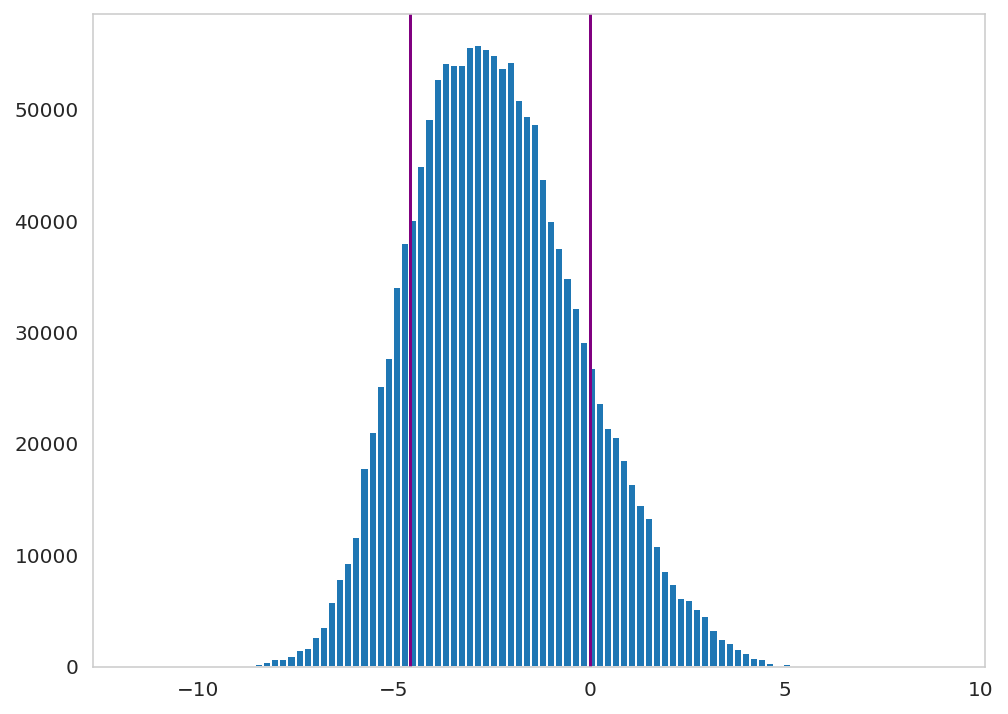

In [16]:
fig = plt.figure(figsize=(8, 6))

ax = plt.hist(signal_df['log_conc_uM_medNorm'],100)

plt.axvline(x=np.log(0.01),c='purple')
plt.axvline(x=np.log(1.0),c='purple')

plt.grid(False)

plt.show()

#fig.savefig('../plots/suppValid_signallingProt_28july2020.png',dpi=300, bbox_inches='tight', transparent=True)
#fig.savefig('../plots/suppValid_signallingProt_28july2020.svg', transparent=True)
